Imports

In [6]:
from PIL import Image
from tqdm import tqdm
import json as js
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir as ld
from os import path, makedirs
from keras.models import Model #type: ignore
from keras.utils import to_categorical #type: ignore
from keras.losses import Huber #type: ignore
from collections import defaultdict
import random
from PIL import Image, ImageEnhance, ImageFilter, ImageOps

Involving paths

In [7]:
with open("config_CNN.json",'r') as file:
    paths = js.load(file)

Image Resizing

In [9]:
RESIZE_TO = (128, 128)

def adjust_bbox_for_resize(bbox, original_size, new_size):
    x, y, w, h = bbox
    scale_x = new_size[0] / original_size[0]
    scale_y = new_size[1] / original_size[1]
    return [x * scale_x, y * scale_y, w * scale_x, h * scale_y]

def flip_bbox(bbox):
    x, y, w, h = bbox
    return [1.0 - x - w, y, w, h]

def rotate_bbox(bbox):
    x, y, w, h = bbox
    return [y, 1.0 - x - w, h, w]

def resize_and_balance(input_folder, output_folder, annotations_file, output_json, target_count=500):
    if not path.exists(output_folder):
        makedirs(output_folder)

    with open(annotations_file, 'r') as f:
        annotations = js.load(f)

    class_dict = defaultdict(list)
    for info in annotations:
        class_dict[info["category_id"]].append(info)

    new_annotations = []

    for label, items in class_dict.items():
        print(f"\nProcessing Class {label}")
        random.shuffle(items)
        selected_items = items[:target_count] if len(items) >= target_count else items.copy()

        augment_index = 0
        while len(selected_items) < target_count:
            original = random.choice(items)
            filename = original["img_id"]
            original_bbox = original["bbox"]
            input_path = path.join(input_folder, filename)

            try:
                with Image.open(input_path) as img:
                    original_size = img.size
                    img_resized = img.resize(RESIZE_TO, Image.LANCZOS)
                    bbox_resized = adjust_bbox_for_resize(original_bbox, original_size, RESIZE_TO)

                    # Augmentation 1: Horizontal Flip
                    img_flip = ImageOps.mirror(img_resized)
                    bbox_flip = flip_bbox(bbox_resized)
                    flip_name = filename.replace('.jpg', f'_flip{augment_index}.jpg')
                    img_flip.save(path.join(output_folder, flip_name))
                    selected_items.append({"img_id": flip_name, "bbox": bbox_flip, "category_id": label})
                    if len(selected_items) >= target_count: break

                    # Augmentation 2: Rotation
                    img_rot = img_resized.rotate(90, expand=True).resize(RESIZE_TO)
                    bbox_rot = rotate_bbox(bbox_resized)
                    rot_name = filename.replace('.jpg', f'_rot{augment_index}.jpg')
                    img_rot.save(path.join(output_folder, rot_name))
                    selected_items.append({"img_id": rot_name, "bbox": bbox_rot, "category_id": label})
                    if len(selected_items) >= target_count: break

                    # Augmentation 3: Brightness
                    bright = ImageEnhance.Brightness(img_resized).enhance(random.uniform(0.6, 1.4))
                    bright_name = filename.replace('.jpg', f'_bright{augment_index}.jpg')
                    bright.save(path.join(output_folder, bright_name))
                    selected_items.append({"img_id": bright_name, "bbox": bbox_resized, "category_id": label})
                    if len(selected_items) >= target_count: break

                    # Augmentation 4: Gaussian Blur
                    blurred = img_resized.filter(ImageFilter.GaussianBlur(radius=1.5))
                    blur_name = filename.replace('.jpg', f'_blur{augment_index}.jpg')
                    blurred.save(path.join(output_folder, blur_name))
                    selected_items.append({"img_id": blur_name, "bbox": bbox_resized, "category_id": label})
                    if len(selected_items) >= target_count: break

                    augment_index += 1

            except Exception as e:
                print(f"Augmentation failed for {filename}: {e}")
                continue

        for info in tqdm(selected_items[:target_count], desc=f"Saving Class {label}"):
            filename = info["img_id"]
            bbox = info["bbox"]
            input_path = path.join(input_folder, filename)
            output_path = path.join(output_folder, filename)

            try:
                if not path.exists(output_path):
                    with Image.open(input_path) as img:
                        original_size = img.size
                        img_resized = img.resize(RESIZE_TO, Image.LANCZOS)
                        img_resized.save(output_path)

                        # Only resize bbox if original (not already resized or augmented)
                        if "flip" not in filename and "rot" not in filename and "bright" not in filename and "blur" not in filename:
                            bbox = adjust_bbox_for_resize(bbox, original_size, RESIZE_TO)

                new_annotations.append({
                    "img_id": filename,
                    "bbox": bbox,
                    "category_id": label
                })

            except Exception as e:
                print(f"Skipping {filename}: {e}")

    with open(output_json, 'w') as f:
        js.dump(new_annotations, f, indent=2)

input_folder_train = paths["Train_folder"]
output_folder_train = paths["Train_resized"]
input_folder_val = paths["Validation_folder"]
output_folder_val = paths["Validation_resized"]
annotation_train = paths["Max_Area_Train_Json"]
annotation_val = paths["Max_Area_Val_Json"]
output_json_train = paths["Preprocessed_Train_json"]
output_json_val = paths["Preprocessed_Validation_json"]

resize_and_balance(
    input_folder_train,
    output_folder_train,
    annotation_train,
    output_json_train,
    target_count=500
)

resize_and_balance(
    input_folder_val,
    output_folder_val,
    annotation_val,
    output_json_val,
    target_count=500
)


Processing Class 1


Saving Class 1: 100%|██████████| 500/500 [00:03<00:00, 125.59it/s]



Processing Class 21


Saving Class 21: 100%|██████████| 500/500 [00:04<00:00, 119.52it/s]



Processing Class 79


Saving Class 79: 100%|██████████| 500/500 [00:03<00:00, 128.52it/s]



Processing Class 78


Saving Class 78: 100%|██████████| 500/500 [00:01<00:00, 270.47it/s]



Processing Class 70


Saving Class 70: 100%|██████████| 500/500 [00:03<00:00, 138.41it/s]



Processing Class 7


Saving Class 7: 100%|██████████| 500/500 [00:04<00:00, 121.91it/s]



Processing Class 82


Saving Class 82: 100%|██████████| 500/500 [00:03<00:00, 139.68it/s]



Processing Class 62


Saving Class 62: 100%|██████████| 500/500 [00:03<00:00, 133.40it/s]



Processing Class 81


Saving Class 81: 100%|██████████| 500/500 [00:03<00:00, 140.09it/s]



Processing Class 8


Saving Class 8: 100%|██████████| 500/500 [00:03<00:00, 126.24it/s]



Processing Class 67


Saving Class 67: 100%|██████████| 500/500 [00:03<00:00, 125.75it/s]



Processing Class 9


Saving Class 9: 100%|██████████| 500/500 [00:03<00:00, 131.24it/s]



Processing Class 22


Saving Class 22: 100%|██████████| 500/500 [00:04<00:00, 116.84it/s]



Processing Class 2


Saving Class 2: 100%|██████████| 500/500 [00:03<00:00, 127.37it/s]



Processing Class 64


Saving Class 64: 100%|██████████| 500/500 [00:03<00:00, 127.98it/s]



Processing Class 3


Saving Class 3: 100%|██████████| 500/500 [00:03<00:00, 131.02it/s]



Processing Class 6


Saving Class 6: 100%|██████████| 500/500 [00:04<00:00, 124.89it/s]



Processing Class 4


Saving Class 4: 100%|██████████| 500/500 [00:04<00:00, 121.80it/s]



Processing Class 17


Saving Class 17: 100%|██████████| 500/500 [00:03<00:00, 141.31it/s]



Processing Class 85


Saving Class 85: 100%|██████████| 500/500 [00:03<00:00, 125.88it/s]



Processing Class 86


Saving Class 86: 100%|██████████| 500/500 [00:03<00:00, 134.91it/s]



Processing Class 19


Saving Class 19: 100%|██████████| 500/500 [00:04<00:00, 124.56it/s]



Processing Class 51


Saving Class 51: 100%|██████████| 500/500 [00:03<00:00, 130.05it/s]



Processing Class 73


Saving Class 73: 100%|██████████| 500/500 [00:03<00:00, 143.63it/s]



Processing Class 72


Saving Class 72: 100%|██████████| 500/500 [00:03<00:00, 144.26it/s]



Processing Class 52


Saving Class 52: 100%|██████████| 500/500 [00:03<00:00, 126.75it/s]



Processing Class 47


Saving Class 47: 100%|██████████| 500/500 [00:02<00:00, 222.87it/s]



Processing Class 15


Saving Class 15: 100%|██████████| 500/500 [00:03<00:00, 125.08it/s]



Processing Class 5


Saving Class 5: 100%|██████████| 500/500 [00:03<00:00, 139.25it/s]



Processing Class 10


Saving Class 10: 100%|██████████| 500/500 [00:03<00:00, 135.68it/s]



Processing Class 25


Saving Class 25: 100%|██████████| 500/500 [00:04<00:00, 123.91it/s]



Processing Class 20


Saving Class 20: 100%|██████████| 500/500 [00:04<00:00, 117.89it/s]



Processing Class 18


Saving Class 18: 100%|██████████| 500/500 [00:03<00:00, 134.78it/s]



Processing Class 11


Saving Class 11: 100%|██████████| 500/500 [00:03<00:00, 127.96it/s]



Processing Class 16


Saving Class 16: 100%|██████████| 500/500 [00:04<00:00, 114.70it/s]



Processing Class 13


Saving Class 13: 100%|██████████| 500/500 [00:07<00:00, 63.12it/s]



Processing Class 84


Saving Class 84: 100%|██████████| 500/500 [00:05<00:00, 85.84it/s]



Processing Class 28


Saving Class 28: 100%|██████████| 500/500 [00:08<00:00, 61.19it/s]



Processing Class 14


Saving Class 14: 100%|██████████| 500/500 [00:03<00:00, 135.81it/s]



Processing Class 65


Saving Class 65: 100%|██████████| 500/500 [00:06<00:00, 76.50it/s] 



Processing Class 33


Saving Class 33: 100%|██████████| 500/500 [00:03<00:00, 133.82it/s]



Processing Class 63


Saving Class 63: 100%|██████████| 500/500 [00:03<00:00, 136.89it/s]



Processing Class 76


Saving Class 76: 100%|██████████| 500/500 [00:01<00:00, 299.45it/s]



Processing Class 32


Saving Class 32: 100%|██████████| 500/500 [00:00<00:00, 983.73it/s]



Processing Class 46


Saving Class 46: 100%|██████████| 500/500 [00:00<00:00, 930.20it/s]



Processing Class 23


Saving Class 23: 100%|██████████| 500/500 [00:04<00:00, 116.57it/s]



Processing Class 24


Saving Class 24: 100%|██████████| 500/500 [00:03<00:00, 125.20it/s]



Processing Class 61


Saving Class 61: 100%|██████████| 500/500 [00:03<00:00, 127.53it/s]



Processing Class 53


Saving Class 53: 100%|██████████| 500/500 [00:02<00:00, 234.32it/s]



Processing Class 55


Saving Class 55: 100%|██████████| 500/500 [00:02<00:00, 196.09it/s]



Processing Class 50


Saving Class 50: 100%|██████████| 500/500 [00:00<00:00, 2106.62it/s]



Processing Class 60


Saving Class 60: 100%|██████████| 500/500 [00:03<00:00, 157.11it/s]



Processing Class 56


Saving Class 56: 100%|██████████| 500/500 [00:03<00:00, 125.34it/s]



Processing Class 44


Saving Class 44: 100%|██████████| 500/500 [00:01<00:00, 298.52it/s]



Processing Class 57


Saving Class 57: 100%|██████████| 500/500 [00:01<00:00, 349.28it/s]



Processing Class 36


Saving Class 36: 100%|██████████| 500/500 [00:00<00:00, 652.55it/s]



Processing Class 54


Saving Class 54: 100%|██████████| 500/500 [00:03<00:00, 130.67it/s]



Processing Class 58


Saving Class 58: 100%|██████████| 500/500 [00:02<00:00, 200.95it/s]



Processing Class 42


Saving Class 42: 100%|██████████| 500/500 [00:03<00:00, 128.98it/s]



Processing Class 59


Saving Class 59: 100%|██████████| 500/500 [00:04<00:00, 123.32it/s]



Processing Class 43


Saving Class 43: 100%|██████████| 500/500 [00:00<00:00, 2522.60it/s]



Processing Class 90


Saving Class 90: 100%|██████████| 500/500 [00:00<00:00, 1116.41it/s]



Processing Class 38


Saving Class 38: 100%|██████████| 500/500 [00:03<00:00, 143.95it/s]



Processing Class 88


Saving Class 88: 100%|██████████| 500/500 [00:03<00:00, 133.91it/s]



Processing Class 77


Saving Class 77: 100%|██████████| 500/500 [00:01<00:00, 283.66it/s]



Processing Class 87


Saving Class 87: 100%|██████████| 500/500 [00:01<00:00, 275.28it/s]



Processing Class 31


Saving Class 31: 100%|██████████| 500/500 [00:00<00:00, 582.18it/s]



Processing Class 49


Saving Class 49: 100%|██████████| 500/500 [00:00<00:00, 1243.87it/s]



Processing Class 41


Saving Class 41: 100%|██████████| 500/500 [00:00<00:00, 870.37it/s]



Processing Class 27


Saving Class 27: 100%|██████████| 500/500 [00:00<00:00, 702.68it/s]



Processing Class 35


Saving Class 35: 100%|██████████| 500/500 [00:00<00:00, 1922.66it/s]



Processing Class 75


Saving Class 75: 100%|██████████| 500/500 [00:00<00:00, 642.80it/s]



Processing Class 34


Saving Class 34: 100%|██████████| 500/500 [00:00<00:00, 1337.55it/s]



Processing Class 74


Saving Class 74: 100%|██████████| 500/500 [00:00<00:00, 4002.21it/s]



Processing Class 80


Saving Class 80: 100%|██████████| 500/500 [00:00<00:00, 2821.69it/s]



Processing Class 48


Saving Class 48: 100%|██████████| 500/500 [00:00<00:00, 3167.78it/s]



Processing Class 40


Saving Class 40: 100%|██████████| 500/500 [00:00<00:00, 3736.12it/s]



Processing Class 37


Saving Class 37: 100%|██████████| 500/500 [00:00<00:00, 3454.15it/s]



Processing Class 39


Saving Class 39: 100%|██████████| 500/500 [00:00<00:00, 3586.34it/s]



Processing Class 89


Saving Class 89: 100%|██████████| 500/500 [00:00<00:00, 7981.15it/s]



Processing Class 67


Saving Class 67: 100%|██████████| 500/500 [00:01<00:00, 253.56it/s]



Processing Class 82


Saving Class 82: 100%|██████████| 500/500 [00:00<00:00, 1264.66it/s]



Processing Class 1


Saving Class 1: 100%|██████████| 500/500 [00:03<00:00, 131.80it/s]



Processing Class 2


Saving Class 2: 100%|██████████| 500/500 [00:00<00:00, 2055.98it/s]



Processing Class 70


Saving Class 70: 100%|██████████| 500/500 [00:00<00:00, 749.04it/s]



Processing Class 4


Saving Class 4: 100%|██████████| 500/500 [00:00<00:00, 744.94it/s]



Processing Class 3


Saving Class 3: 100%|██████████| 500/500 [00:00<00:00, 644.86it/s]



Processing Class 84


Saving Class 84: 100%|██████████| 500/500 [00:00<00:00, 4135.48it/s]



Processing Class 64


Saving Class 64: 100%|██████████| 500/500 [00:00<00:00, 3273.50it/s]



Processing Class 63


Saving Class 63: 100%|██████████| 500/500 [00:00<00:00, 916.83it/s]



Processing Class 51


Saving Class 51: 100%|██████████| 500/500 [00:00<00:00, 1167.96it/s]



Processing Class 5


Saving Class 5: 100%|██████████| 500/500 [00:00<00:00, 913.54it/s]



Processing Class 21


Saving Class 21: 100%|██████████| 500/500 [00:00<00:00, 902.85it/s]



Processing Class 15


Saving Class 15: 100%|██████████| 500/500 [00:00<00:00, 818.69it/s]



Processing Class 20


Saving Class 20: 100%|██████████| 500/500 [00:00<00:00, 1412.92it/s]



Processing Class 6


Saving Class 6: 100%|██████████| 500/500 [00:01<00:00, 490.57it/s]



Processing Class 25


Saving Class 25: 100%|██████████| 500/500 [00:00<00:00, 727.21it/s]



Processing Class 16


Saving Class 16: 100%|██████████| 500/500 [00:00<00:00, 1161.60it/s]



Processing Class 7


Saving Class 7: 100%|██████████| 500/500 [00:01<00:00, 428.58it/s]



Processing Class 13


Saving Class 13: 100%|██████████| 500/500 [00:00<00:00, 1977.78it/s]



Processing Class 17


Saving Class 17: 100%|██████████| 500/500 [00:00<00:00, 996.32it/s]



Processing Class 33


Saving Class 33: 100%|██████████| 500/500 [00:00<00:00, 2299.37it/s]



Processing Class 72


Saving Class 72: 100%|██████████| 500/500 [00:00<00:00, 1049.30it/s]



Processing Class 9


Saving Class 9: 100%|██████████| 500/500 [00:00<00:00, 850.73it/s]



Processing Class 22


Saving Class 22: 100%|██████████| 500/500 [00:00<00:00, 779.21it/s]



Processing Class 24


Saving Class 24: 100%|██████████| 500/500 [00:00<00:00, 885.56it/s]



Processing Class 19


Saving Class 19: 100%|██████████| 500/500 [00:00<00:00, 658.49it/s]



Processing Class 56


Saving Class 56: 100%|██████████| 500/500 [00:00<00:00, 2750.46it/s]



Processing Class 60


Saving Class 60: 100%|██████████| 500/500 [00:00<00:00, 3538.83it/s]



Processing Class 54


Saving Class 54: 100%|██████████| 500/500 [00:00<00:00, 2549.20it/s]



Processing Class 65


Saving Class 65: 100%|██████████| 500/500 [00:00<00:00, 695.68it/s]



Processing Class 59


Saving Class 59: 100%|██████████| 500/500 [00:00<00:00, 1197.32it/s]



Processing Class 62


Saving Class 62: 100%|██████████| 500/500 [00:00<00:00, 1200.60it/s]



Processing Class 86


Saving Class 86: 100%|██████████| 500/500 [00:00<00:00, 2198.37it/s]



Processing Class 88


Saving Class 88: 100%|██████████| 500/500 [00:00<00:00, 1454.54it/s]



Processing Class 79


Saving Class 79: 100%|██████████| 500/500 [00:00<00:00, 1486.23it/s]



Processing Class 61


Saving Class 61: 100%|██████████| 500/500 [00:00<00:00, 2654.68it/s]



Processing Class 73


Saving Class 73: 100%|██████████| 500/500 [00:00<00:00, 1048.26it/s]



Processing Class 18


Saving Class 18: 100%|██████████| 500/500 [00:00<00:00, 1115.03it/s]



Processing Class 8


Saving Class 8: 100%|██████████| 500/500 [00:00<00:00, 691.67it/s]



Processing Class 11


Saving Class 11: 100%|██████████| 500/500 [00:00<00:00, 1526.12it/s]



Processing Class 52


Saving Class 52: 100%|██████████| 500/500 [00:00<00:00, 2043.45it/s]



Processing Class 28


Saving Class 28: 100%|██████████| 500/500 [00:00<00:00, 1466.12it/s]



Processing Class 23


Saving Class 23: 100%|██████████| 500/500 [00:00<00:00, 1397.03it/s]



Processing Class 41


Saving Class 41: 100%|██████████| 500/500 [00:00<00:00, 10949.24it/s]



Processing Class 58


Saving Class 58: 100%|██████████| 500/500 [00:00<00:00, 6397.36it/s]



Processing Class 87


Saving Class 87: 100%|██████████| 500/500 [00:00<00:00, 7730.24it/s]



Processing Class 81


Saving Class 81: 100%|██████████| 500/500 [00:00<00:00, 1271.70it/s]



Processing Class 10


Saving Class 10: 100%|██████████| 500/500 [00:00<00:00, 1692.20it/s]



Processing Class 44


Saving Class 44: 100%|██████████| 500/500 [00:00<00:00, 5650.81it/s]



Processing Class 14


Saving Class 14: 100%|██████████| 500/500 [00:00<00:00, 3025.11it/s]



Processing Class 57


Saving Class 57: 100%|██████████| 500/500 [00:00<00:00, 6714.56it/s]



Processing Class 42


Saving Class 42: 100%|██████████| 500/500 [00:00<00:00, 2594.58it/s]



Processing Class 85


Saving Class 85: 100%|██████████| 500/500 [00:00<00:00, 724.09it/s]



Processing Class 77


Saving Class 77: 100%|██████████| 500/500 [00:00<00:00, 6739.48it/s]



Processing Class 48


Saving Class 48: 100%|██████████| 500/500 [00:00<00:00, 14280.52it/s]



Processing Class 76


Saving Class 76: 100%|██████████| 500/500 [00:00<00:00, 13284.13it/s]



Processing Class 38


Saving Class 38: 100%|██████████| 500/500 [00:00<00:00, 2219.40it/s]



Processing Class 49


Saving Class 49: 100%|██████████| 500/500 [00:00<00:00, 28299.35it/s]



Processing Class 27


Saving Class 27: 100%|██████████| 500/500 [00:00<00:00, 18838.44it/s]



Processing Class 47


Saving Class 47: 100%|██████████| 500/500 [00:00<00:00, 6418.12it/s]



Processing Class 34


Saving Class 34: 100%|██████████| 500/500 [00:00<00:00, 18931.98it/s]



Processing Class 53


Saving Class 53: 100%|██████████| 500/500 [00:00<00:00, 7096.60it/s]



Processing Class 55


Saving Class 55: 100%|██████████| 500/500 [00:00<00:00, 4848.67it/s]



Processing Class 78


Saving Class 78: 100%|██████████| 500/500 [00:00<00:00, 7360.99it/s]



Processing Class 36


Saving Class 36: 100%|██████████| 500/500 [00:00<00:00, 20379.50it/s]



Processing Class 80


Saving Class 80: 100%|██████████| 500/500 [00:00<00:00, 31914.78it/s]



Processing Class 89


Saving Class 89: 100%|██████████| 500/500 [00:00<00:00, 35788.80it/s]



Processing Class 50


Saving Class 50: 100%|██████████| 500/500 [00:00<00:00, 55577.25it/s]



Processing Class 90


Saving Class 90: 100%|██████████| 500/500 [00:00<00:00, 40552.10it/s]



Processing Class 43


Saving Class 43: 100%|██████████| 500/500 [00:00<00:00, 31159.86it/s]



Processing Class 75


Saving Class 75: 100%|██████████| 500/500 [00:00<00:00, 41053.81it/s]



Processing Class 40


Saving Class 40: 100%|██████████| 500/500 [00:00<00:00, 75220.66it/s]



Processing Class 32


Saving Class 32: 100%|██████████| 500/500 [00:00<00:00, 49468.13it/s]


Counter

In [10]:
train_json_path = paths["Preprocessed_Train_json"]
val_json_path = paths["Preprocessed_Validation_json"]
Train_Label_Frequency = paths["Train_Label_Frequency"]
Validation_Label_Frequency = paths["Validation_Label_Frequency"]

with open(train_json_path, "r") as file:
    train_json = js.load(file)
    
with open(val_json_path, "r") as file:
    val_json = js.load(file)
    
train_label_freq = {}
val_label_freq = {}

for ann in train_json:
    if ann["label"] not in train_label_freq.keys():
        train_label_freq[ann["label"]] = 1
    else:
        train_label_freq[ann["label"]] += 1
        
print(f"Unique labels in Train: {len(train_label_freq.keys())}")
with open(Train_Label_Frequency, "w") as f:
    js.dump(train_label_freq, f)
    
for ann in val_json:
    if ann["label"] not in val_label_freq.keys():
        val_label_freq[ann["label"]] = 1
    else:
        val_label_freq[ann["label"]] += 1
        
print(f"Unique labels in Validation: {len(val_label_freq.keys())}")
with open(Validation_Label_Frequency, "w") as f:
    js.dump(val_label_freq, f)

KeyError: 'label'

Preprocessing util train

In [ ]:
def get_img_name(id:int):
    for i in data['images']:
        if i["id"]==id:
            return i["file_name"]

def get_category_name(id:int):
    for i in data['categories']:
        if i['id']== id:
            return i["name"]
        
def get_image_size(id:int):
    for i in data['images']:
        if i["id"]==id:
            return (i["width"], i["height"])
        
def get_largest_bounding_box(id:int):
    area_list,bbox_list,cat_list = [0],[0],[0]
    
    for i in data['annotations']:
        if i['image_id']==id:
            area_list.append(i["area"])
            bbox_list.append(i["bbox"])
            cat_list.append(i["category_id"])
            
        else:
            continue
        
    if len(area_list) != 0: 
        max_area = max(area_list)
        bbox = bbox_list[area_list.index(max_area)]
        cat = cat_list[area_list.index(max_area)]
        return bbox,cat

with open("config_CNN.json",'r') as file:
    paths = js.load(file)

with open(paths["Max_Area_Train_Json"], "r") as file:
    data = js.load(file)  

l = []
for i in tqdm(data['images']):
    img = {}
    img["img_id"] = i["file_name"]
    img['size'] = get_image_size(i["id"])
    img["bbox"],img["category_id"] = get_largest_bounding_box(i["id"])
    img["label"] = get_category_name(img["category_id"])
    if img["bbox"] != 0:
        l.append(img)

with open(paths["Preprocessed_Train_json"],'w+') as file:
    js.dump(l, file, indent=4)

Preprocessing util Validation

In [ ]:
def get_img_name(id:int):
    for i in data['images']:
        if i["id"]==id:
            return i["file_name"]

def get_category_name(id:int):
    for i in data['categories']:
        if i['id']== id:
            return i["name"]
        
def get_image_size(id:int):
    for i in data['images']:
        if i["id"]==id:
            return (i["width"], i["height"])
        
def get_largest_bounding_box(id:int):
    area_list,bbox_list,cat_list = [0],[0],[0]
    
    for i in data['annotations']:
        if i['image_id']==id:
            area_list.append(i["area"])
            bbox_list.append(i["bbox"])
            cat_list.append(i["category_id"])
            
        else:
            continue
        
    if len(area_list) != 0: 
        max_area = max(area_list)
        bbox = bbox_list[area_list.index(max_area)]
        cat = cat_list[area_list.index(max_area)]
        return bbox,cat

with open("config_CNN.json",'r') as file:
    paths = js.load(file)

with open(paths["Max_Area_Val_Json"], "r") as file:
    data = js.load(file)  

l = []
for i in data['images']:
    img = {}
    img["img_id"] = i["file_name"]
    img['size'] = get_image_size(i["id"])
    img["bbox"],img["category_id"] = get_largest_bounding_box(i["id"])
    img["label"] = get_category_name(img["category_id"])
    if img["bbox"] != 0:
        l.append(img)

with open(paths["Preprocessed_Validation_json"],'w+') as file:
    js.dump(l, file, indent=4)

Visualization

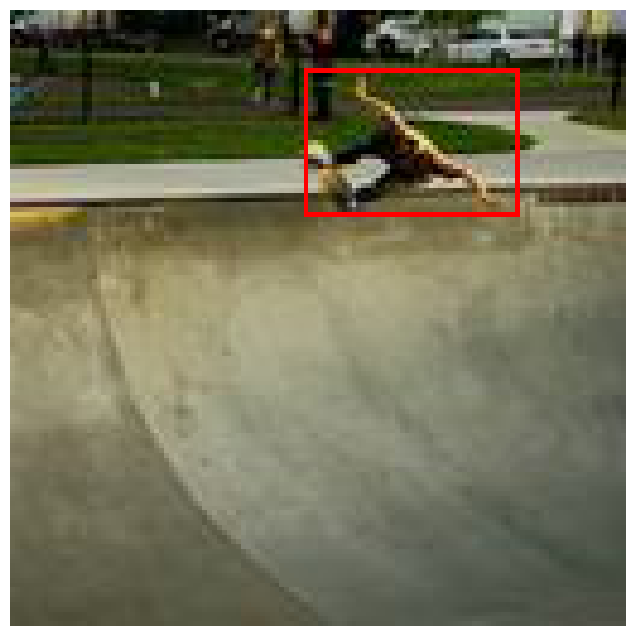

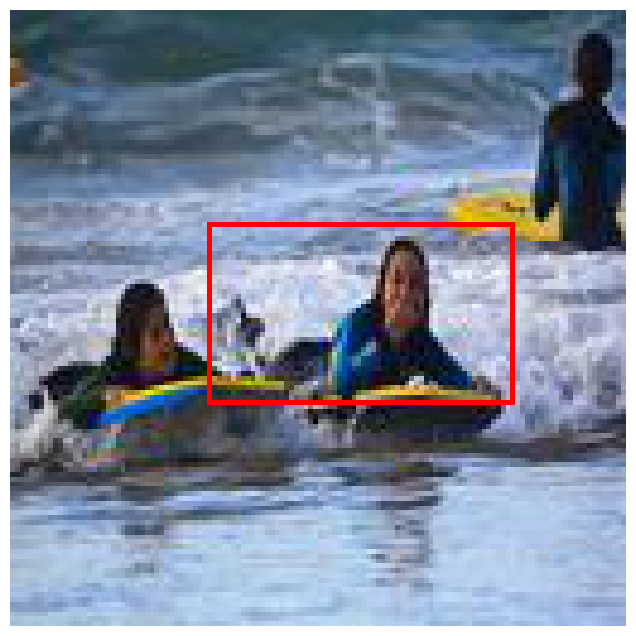

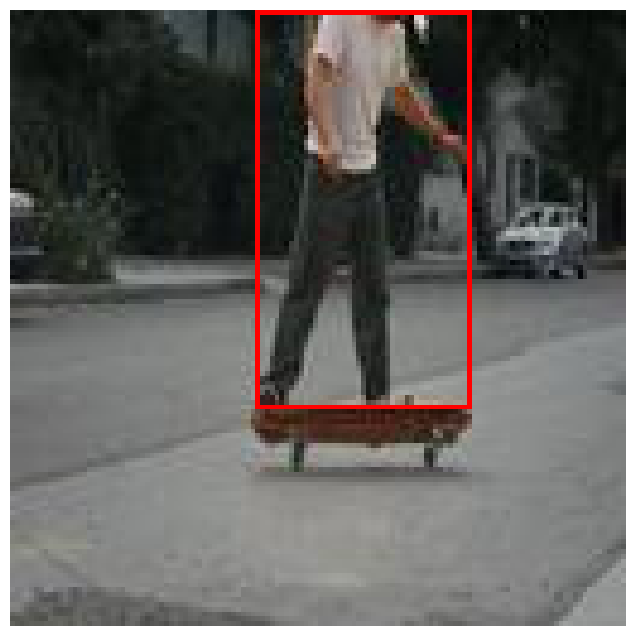

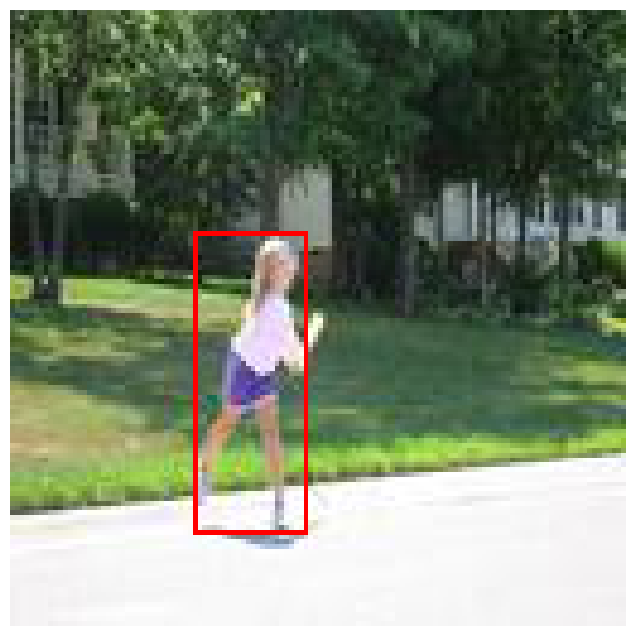

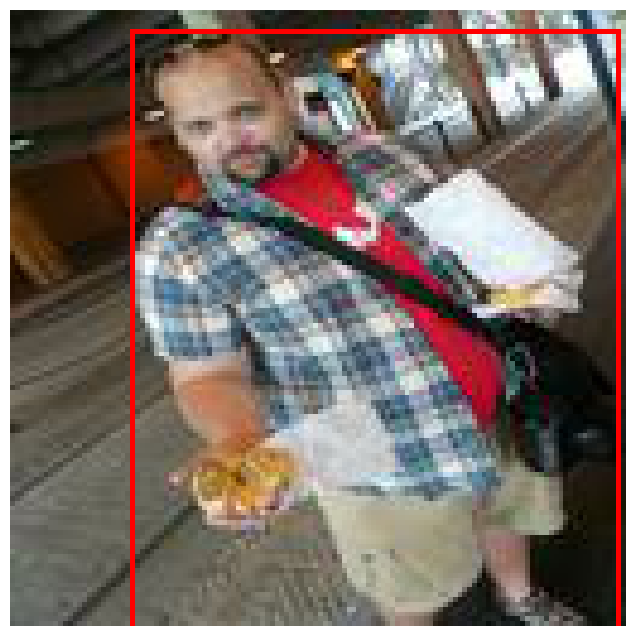

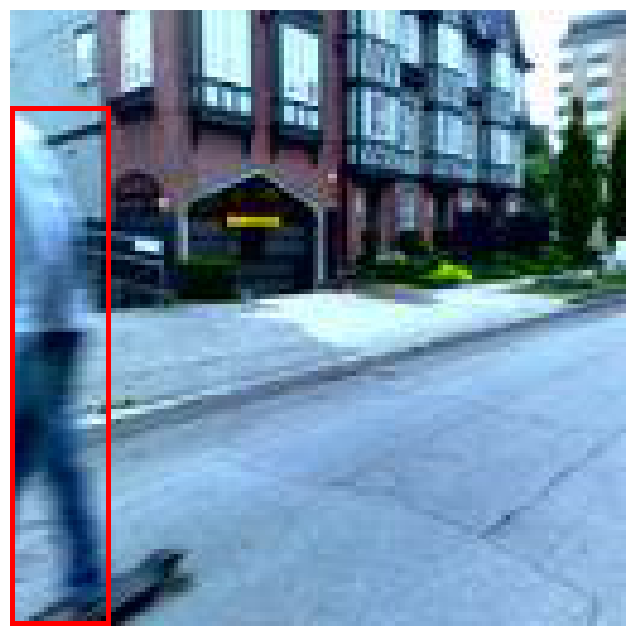

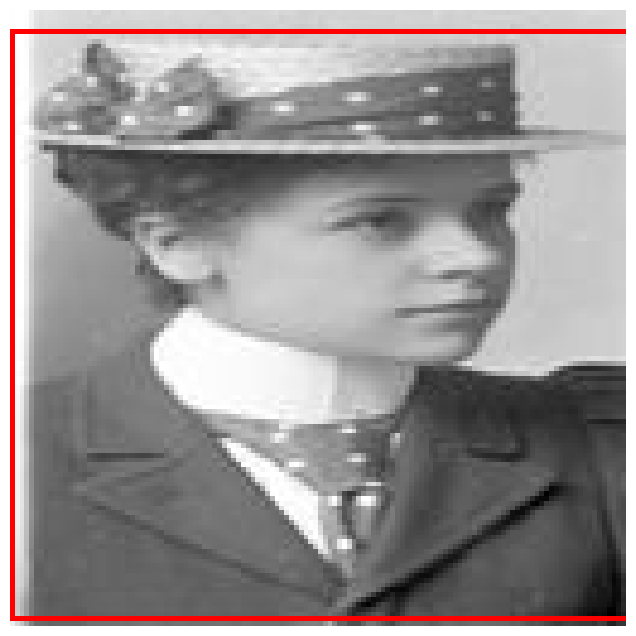

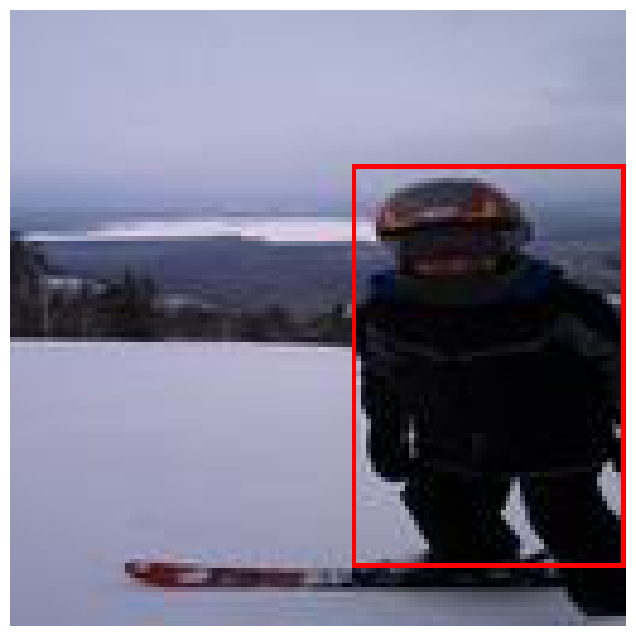

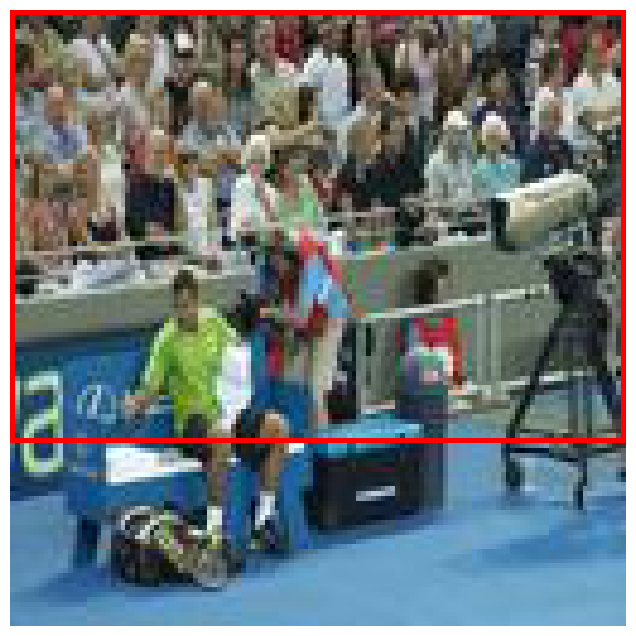

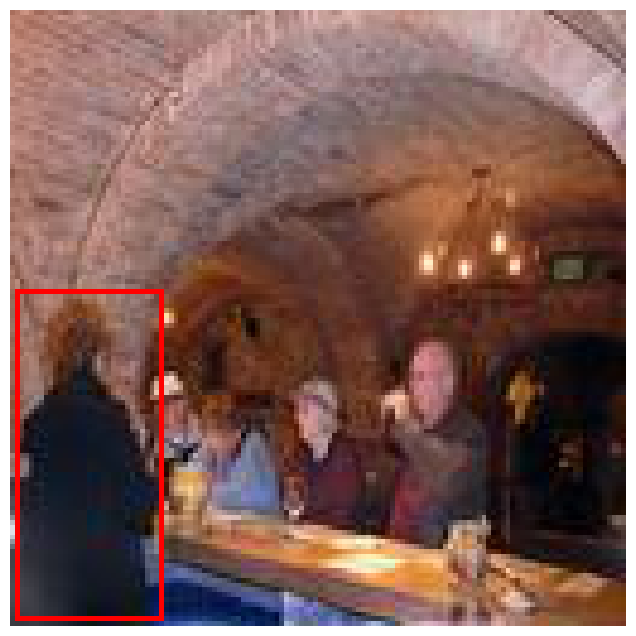

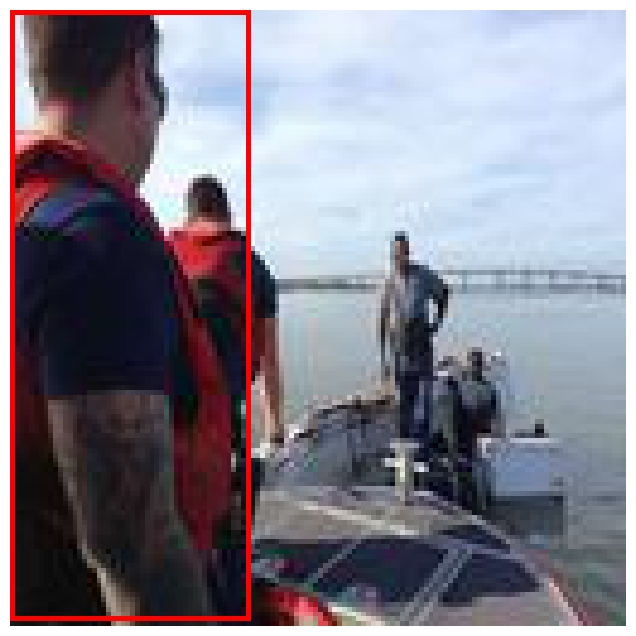

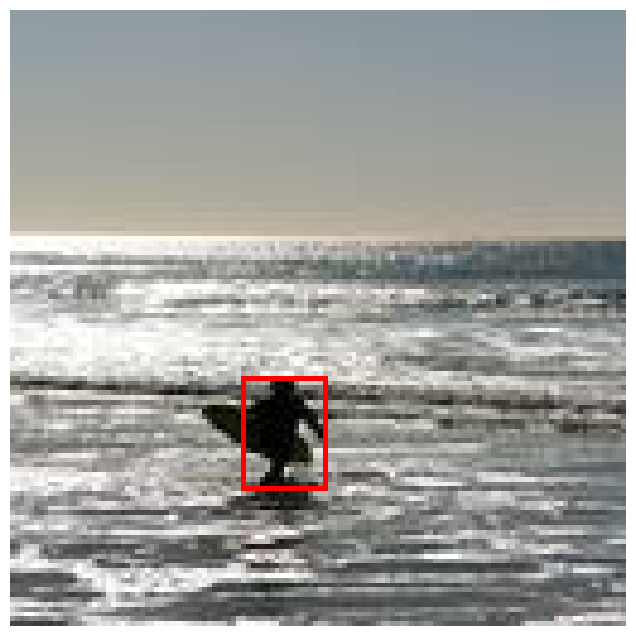

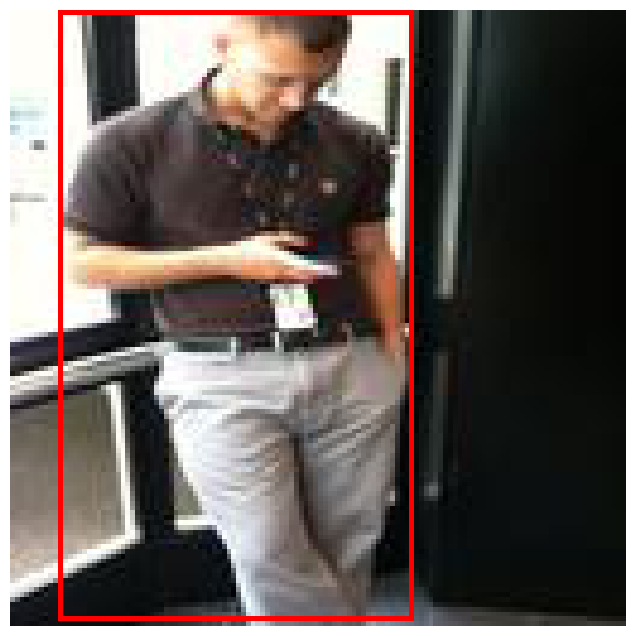

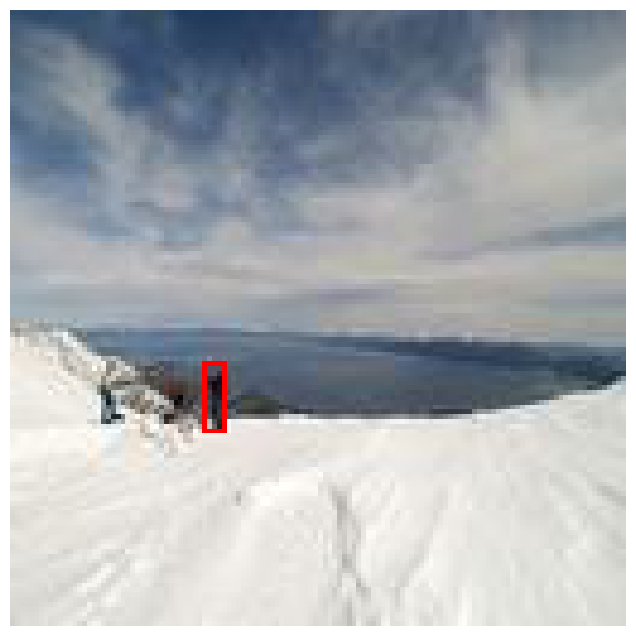

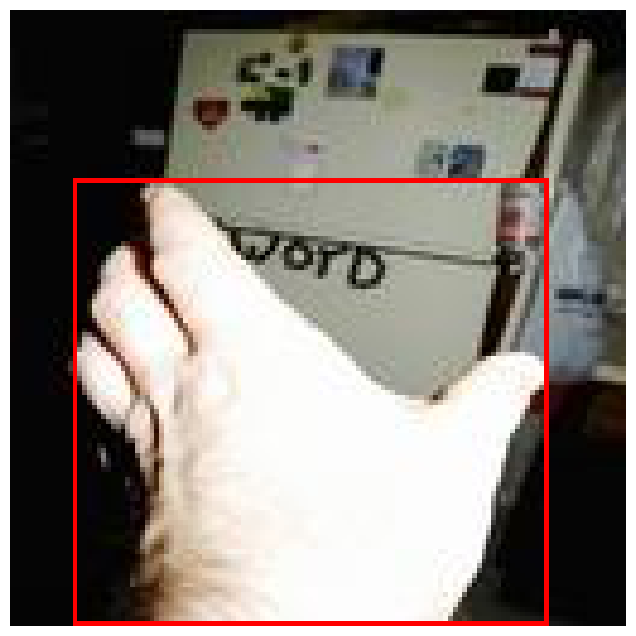

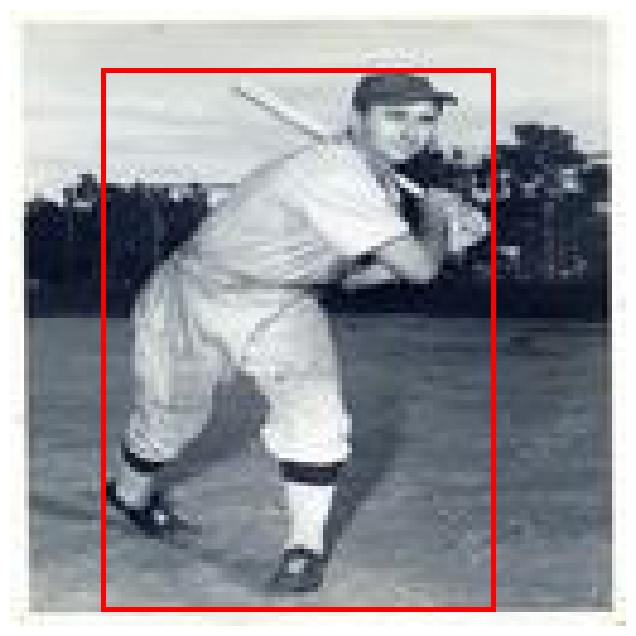

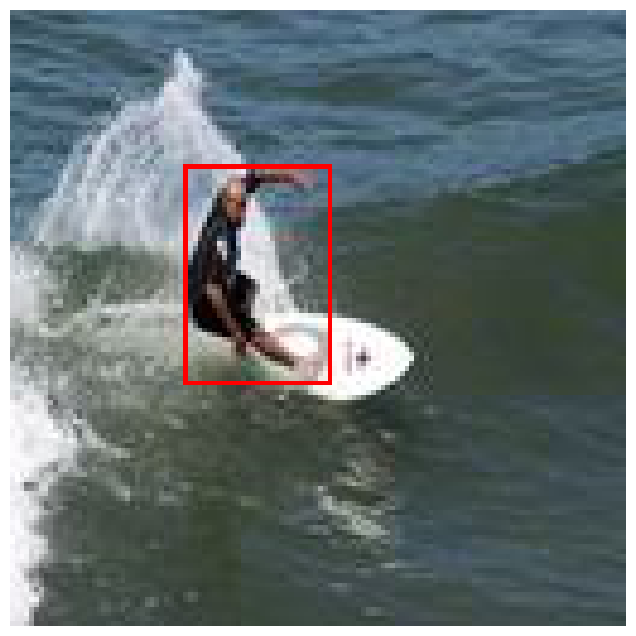

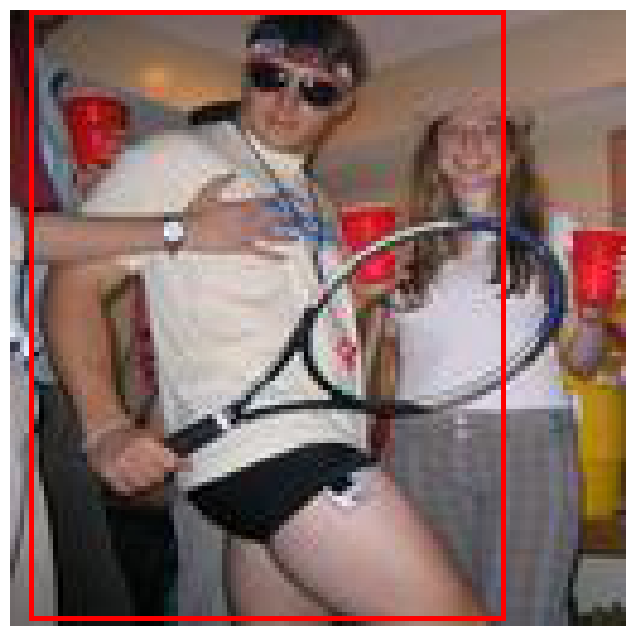

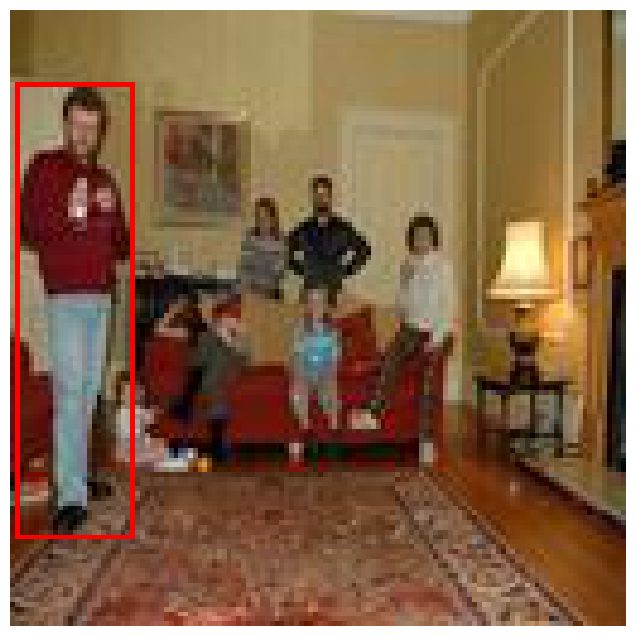

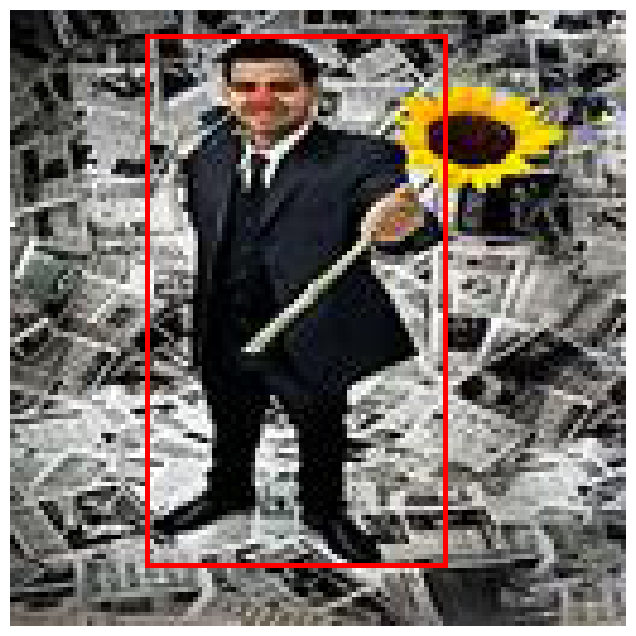

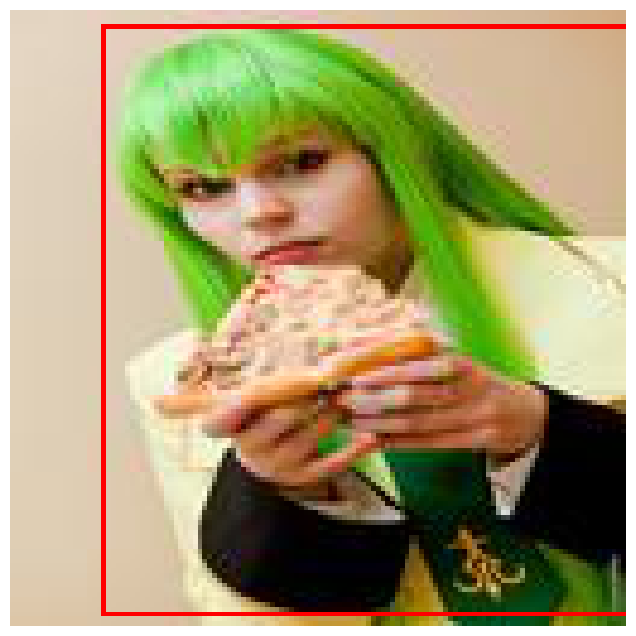

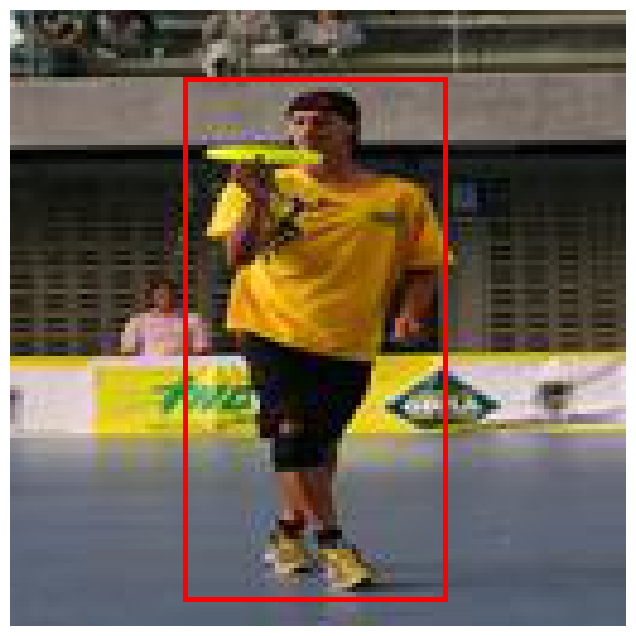

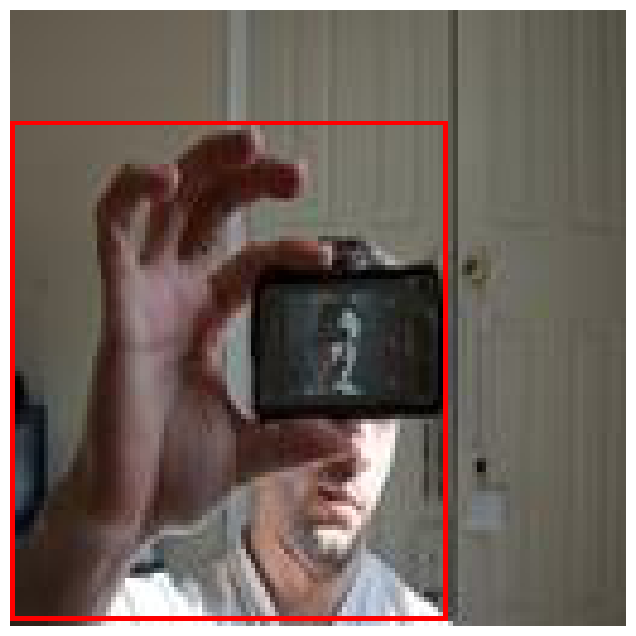

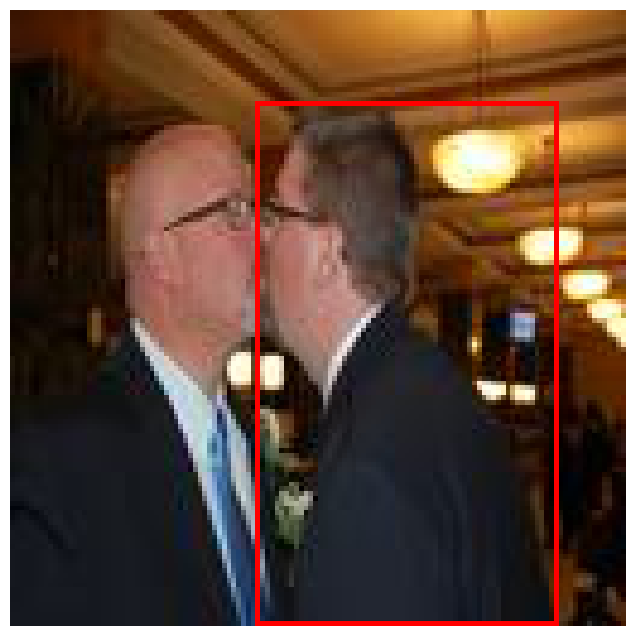

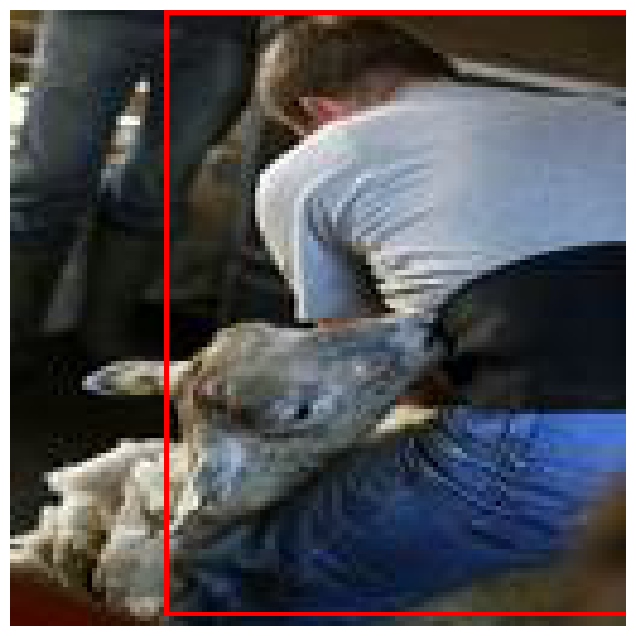

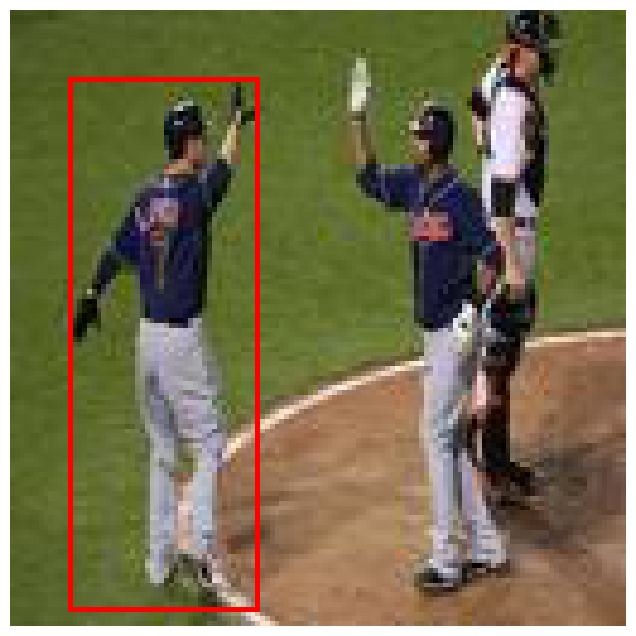

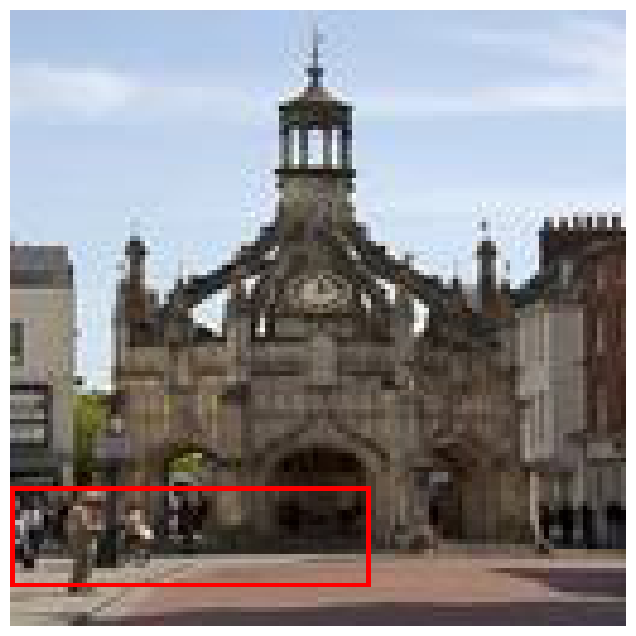

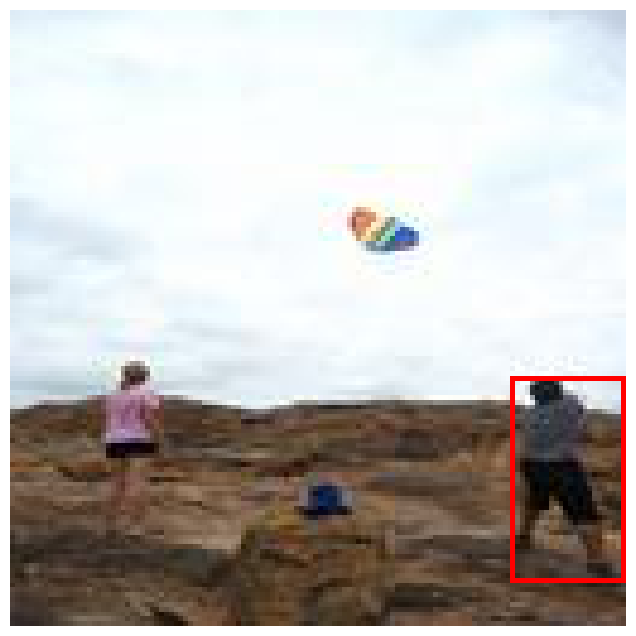

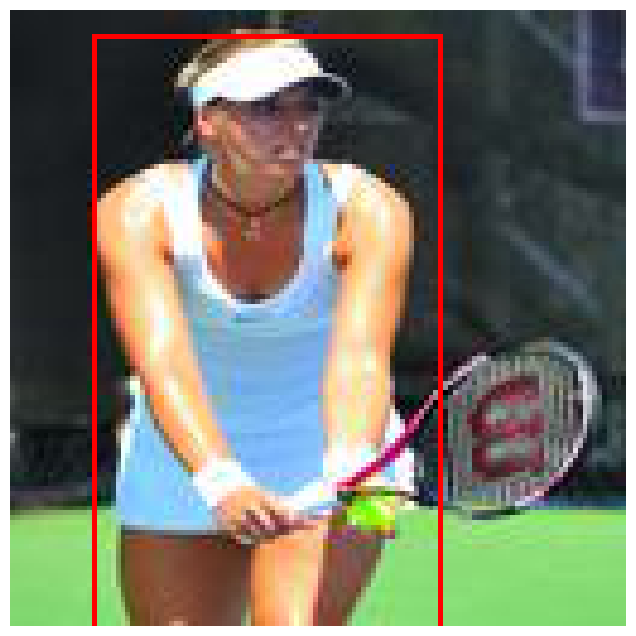

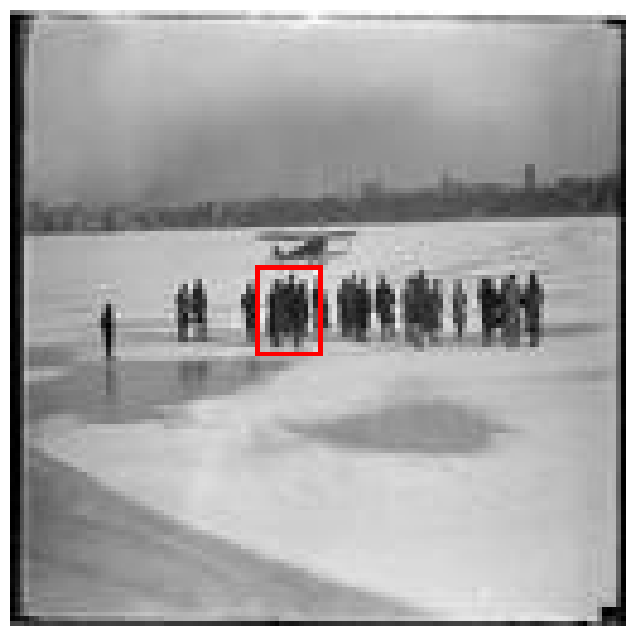

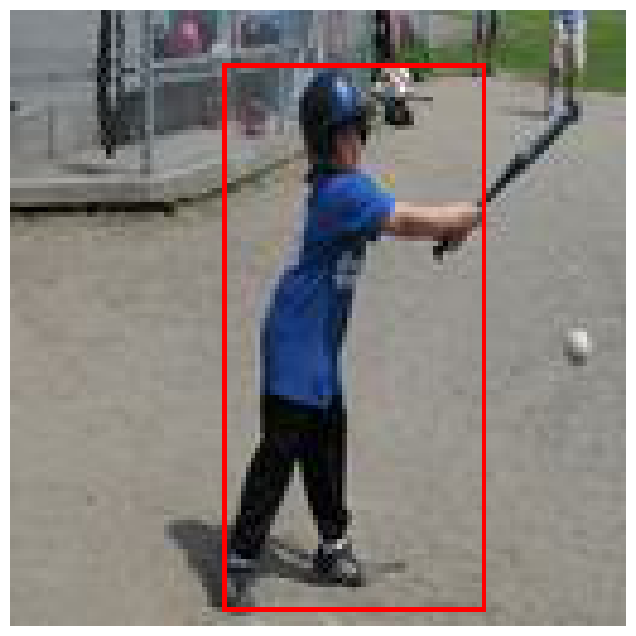

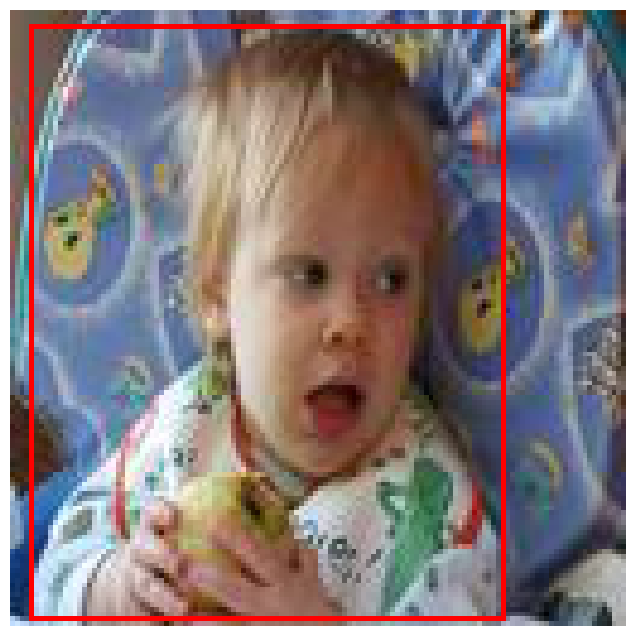

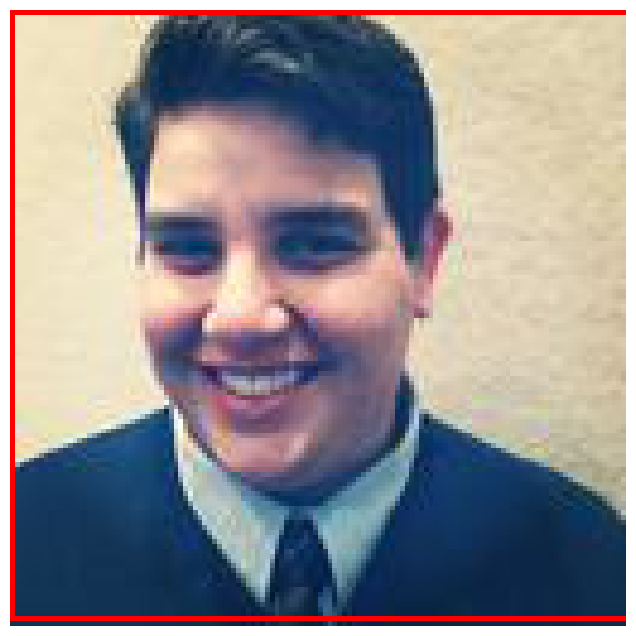

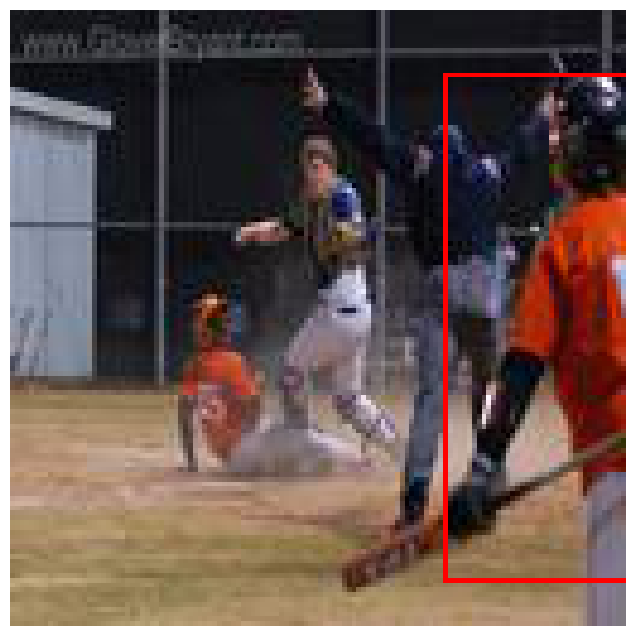

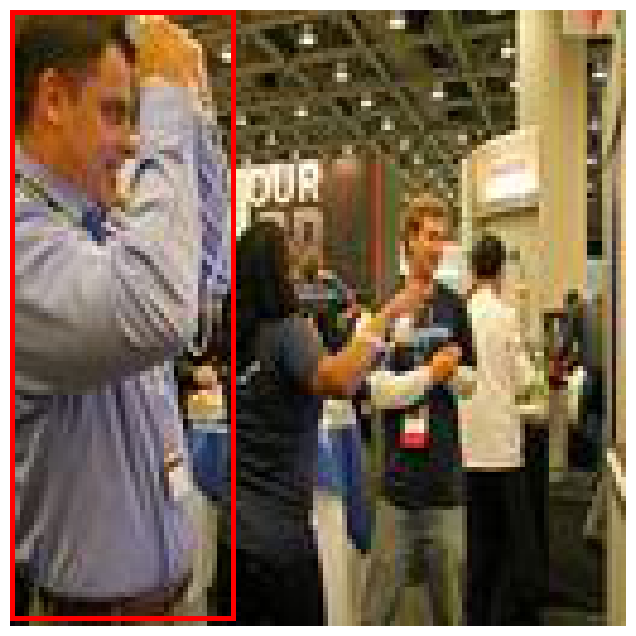

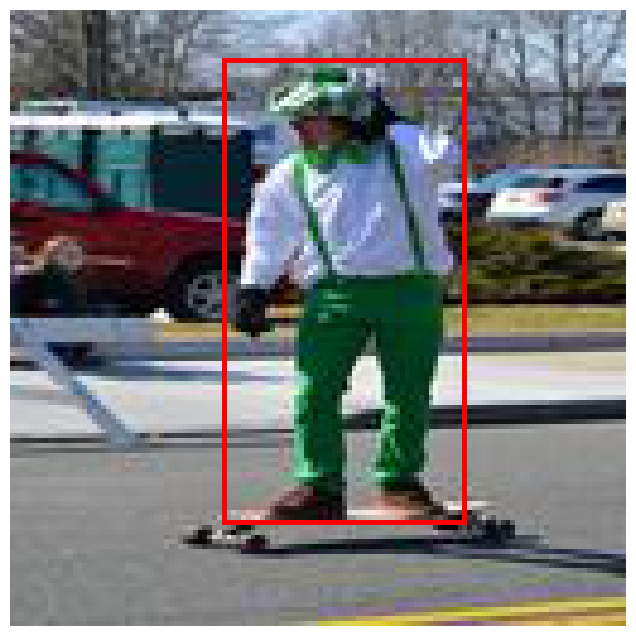

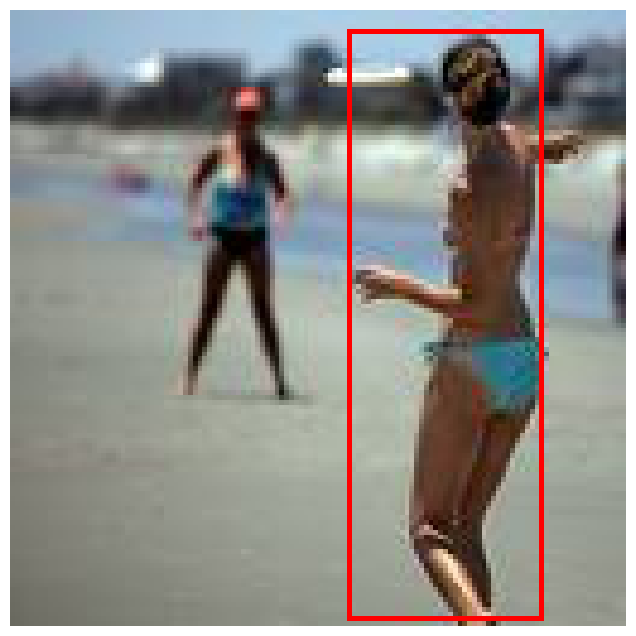

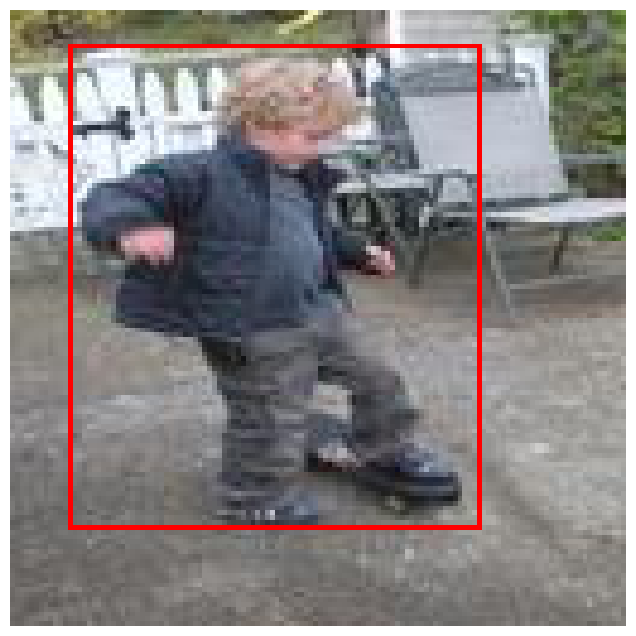

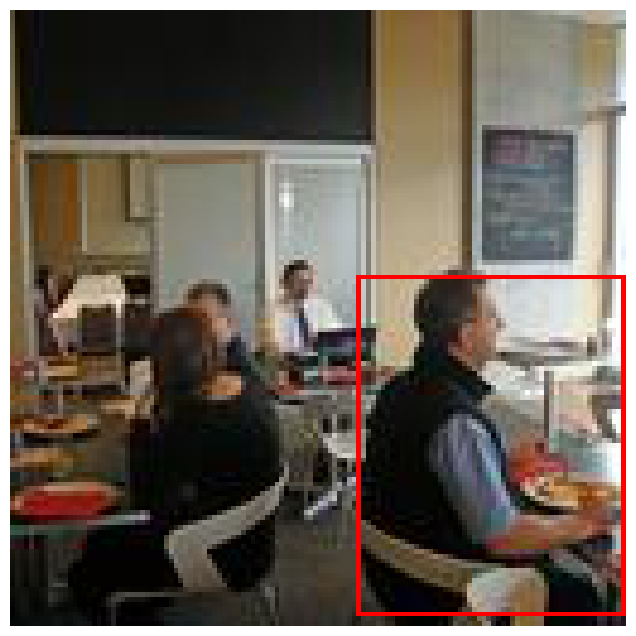

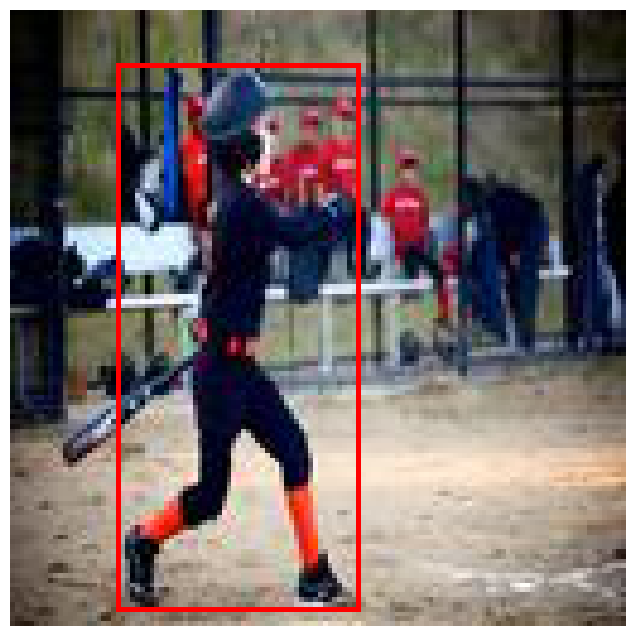

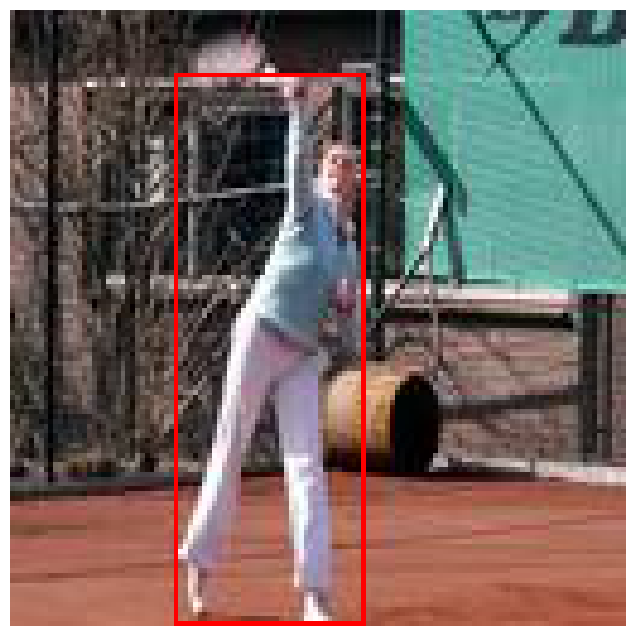

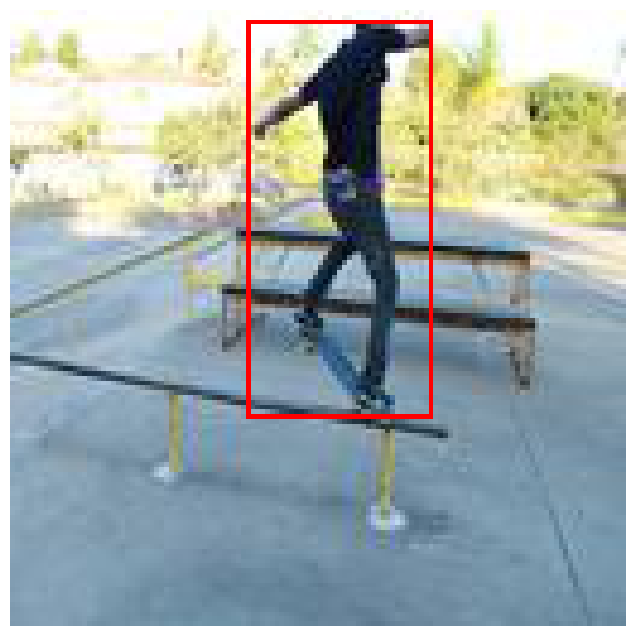

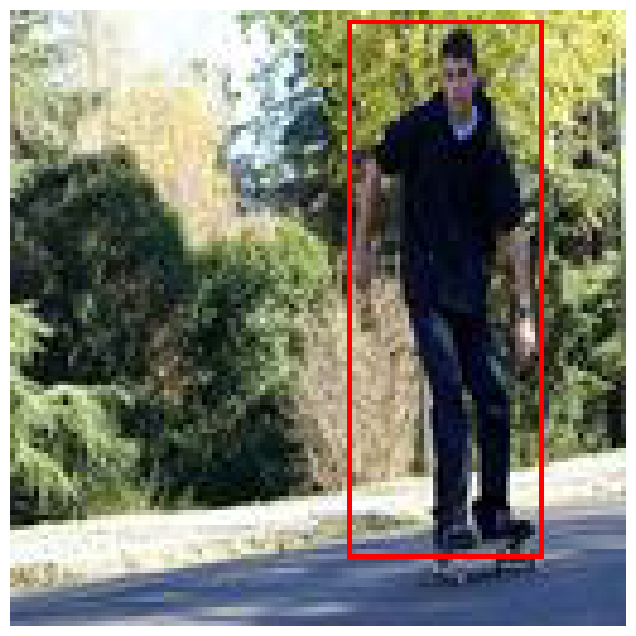

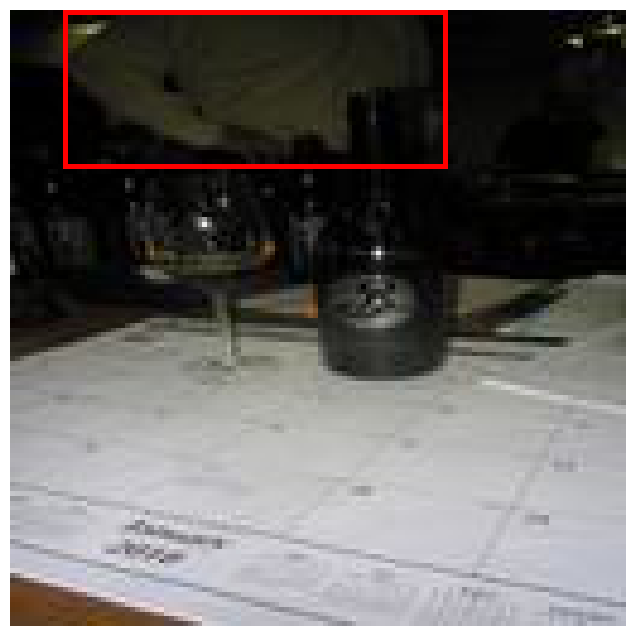

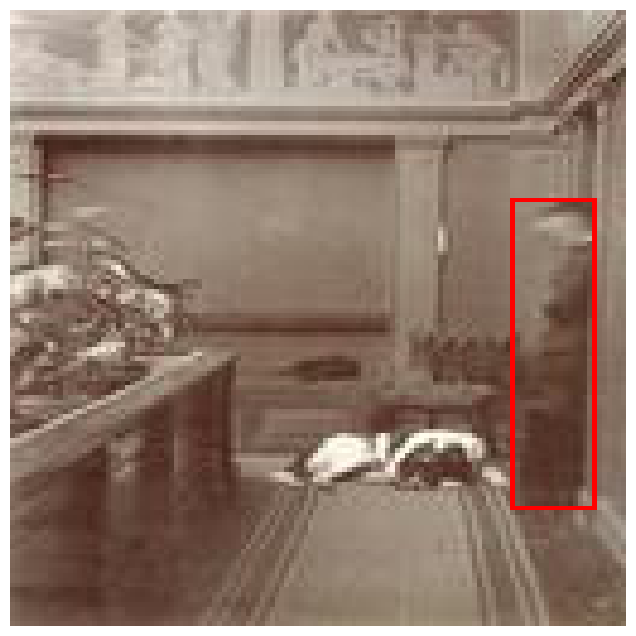

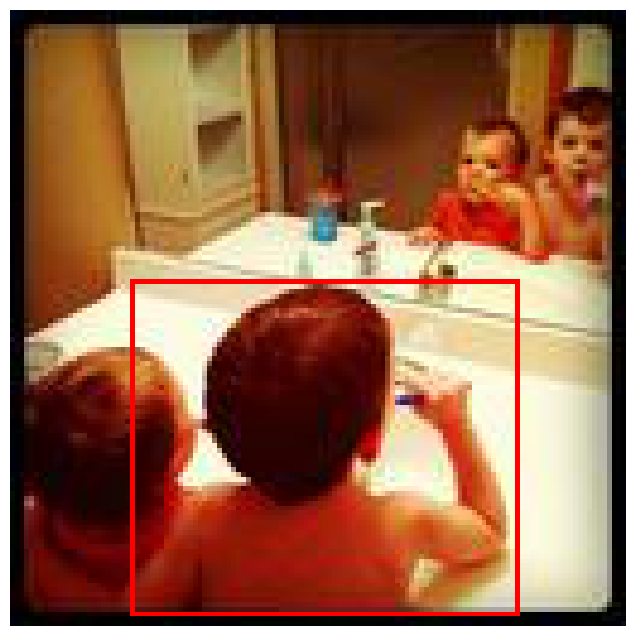

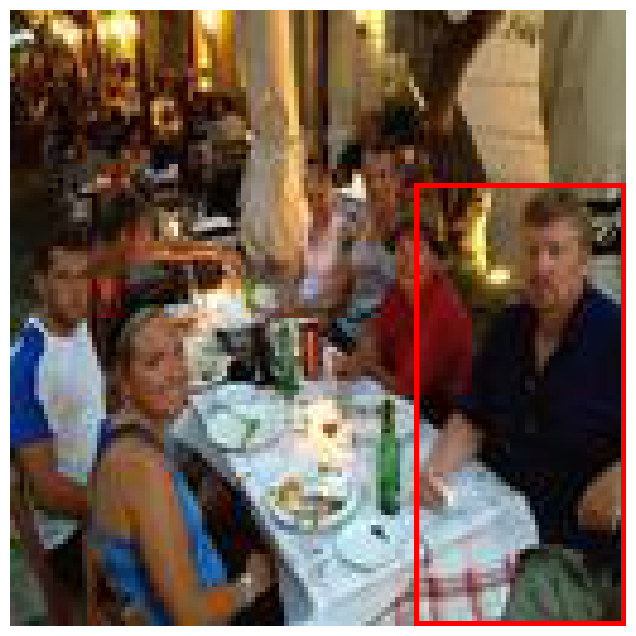

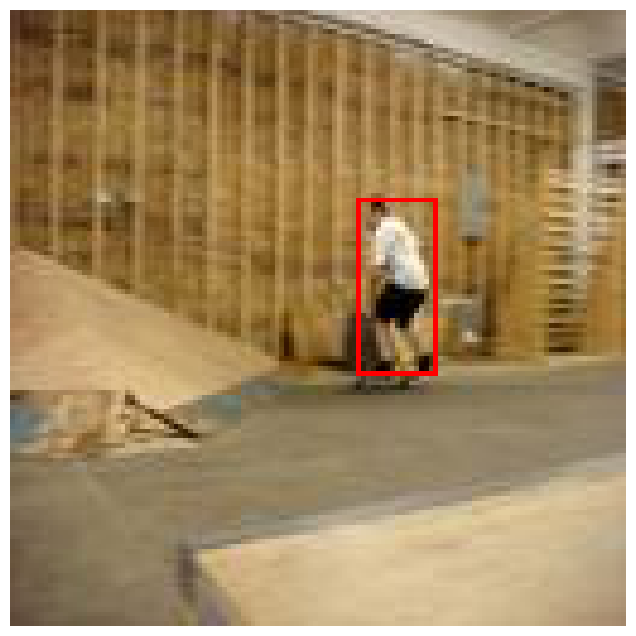

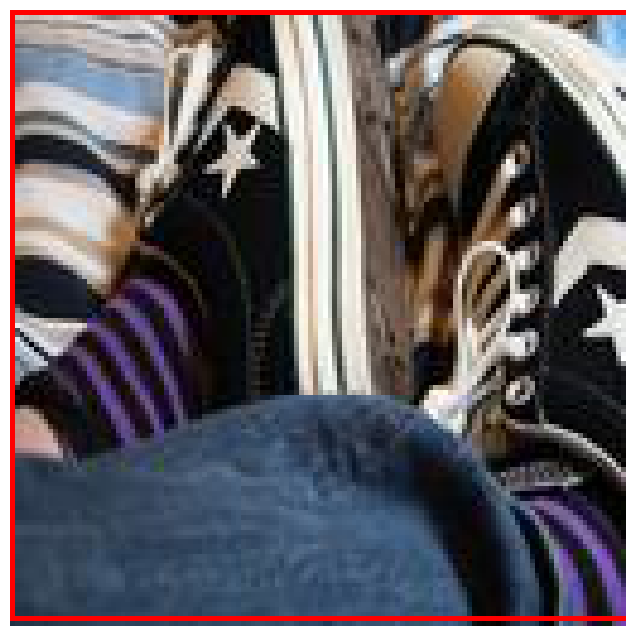

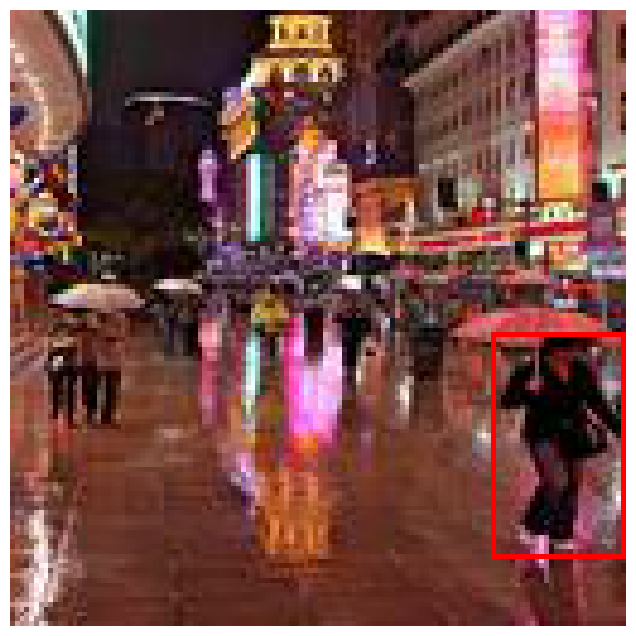

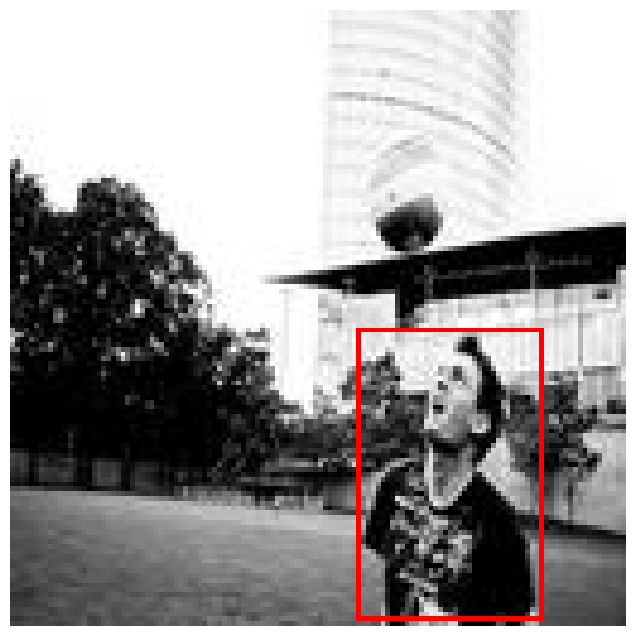

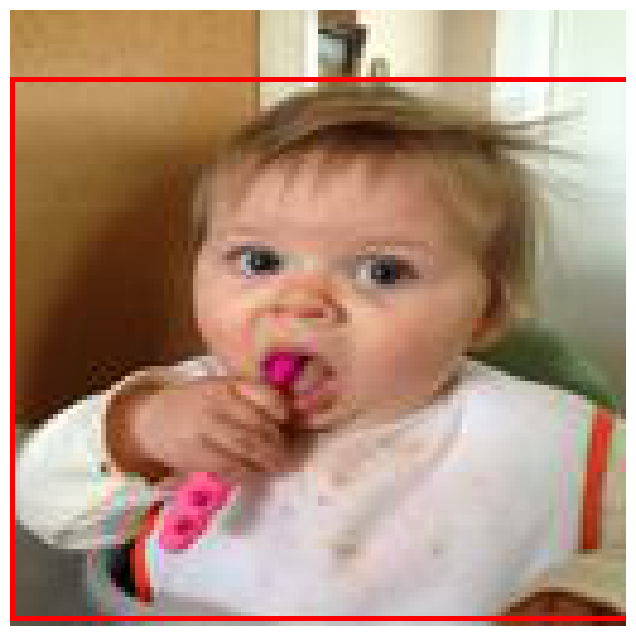

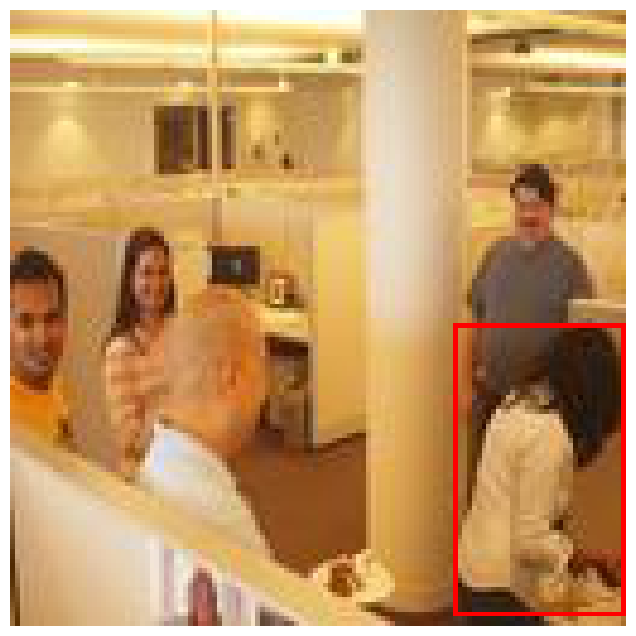

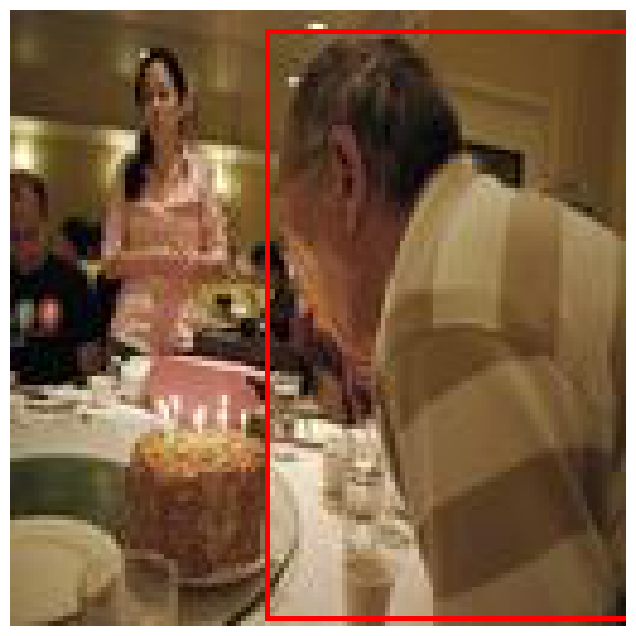

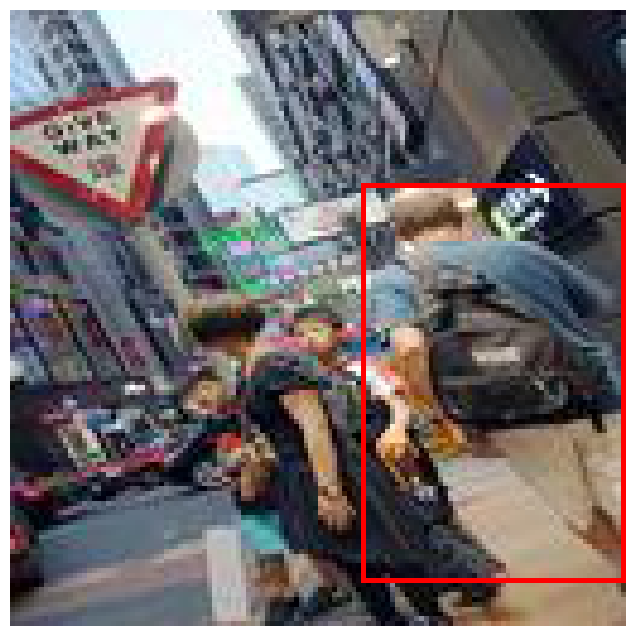

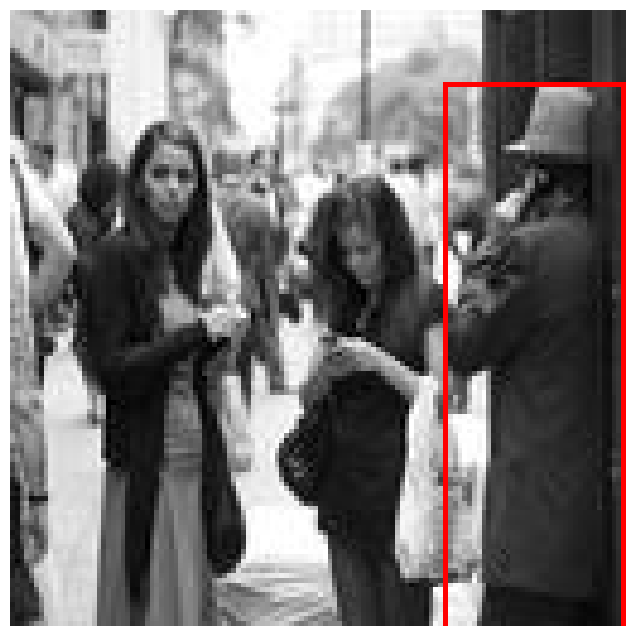

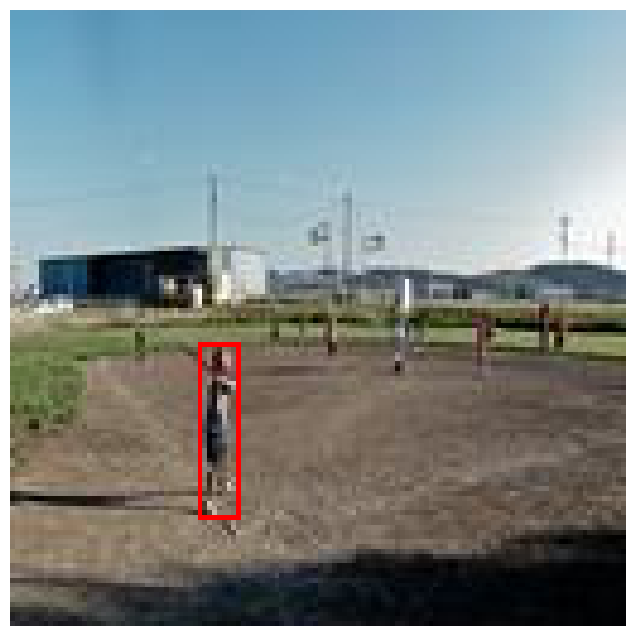

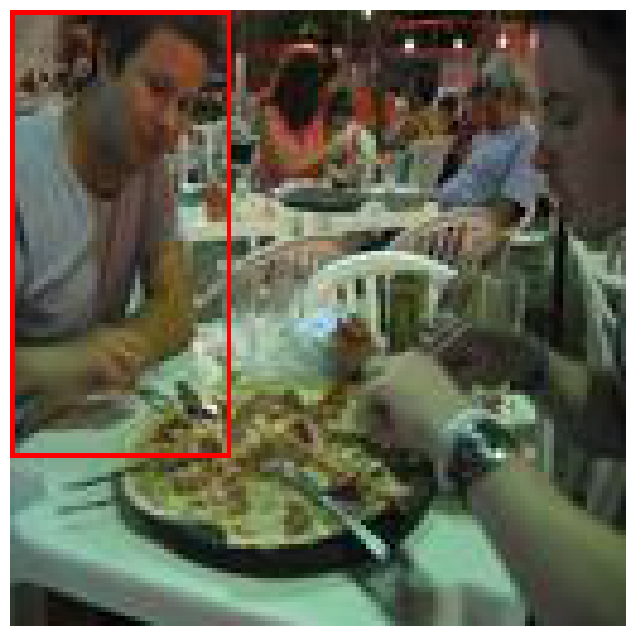

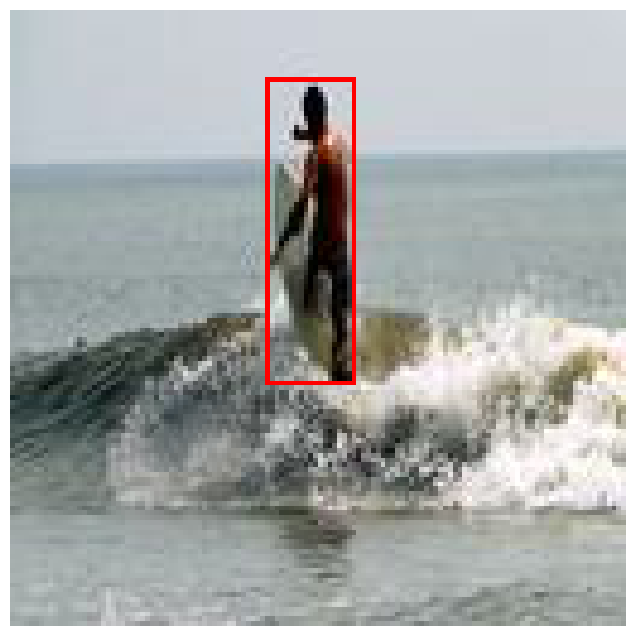

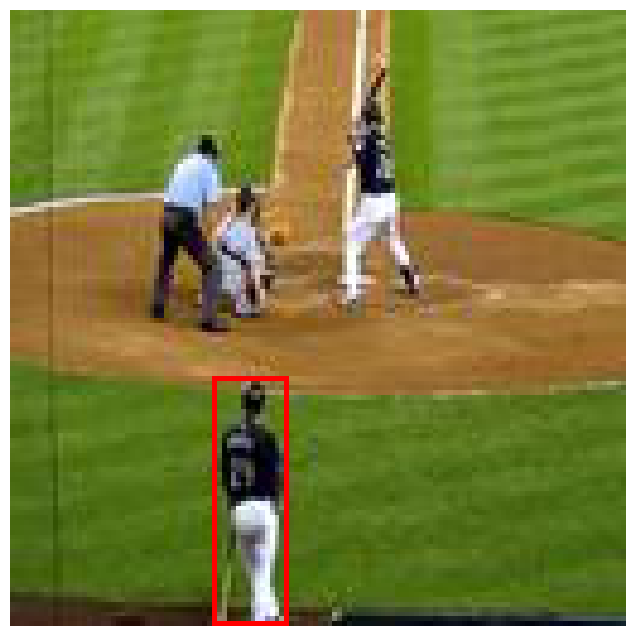

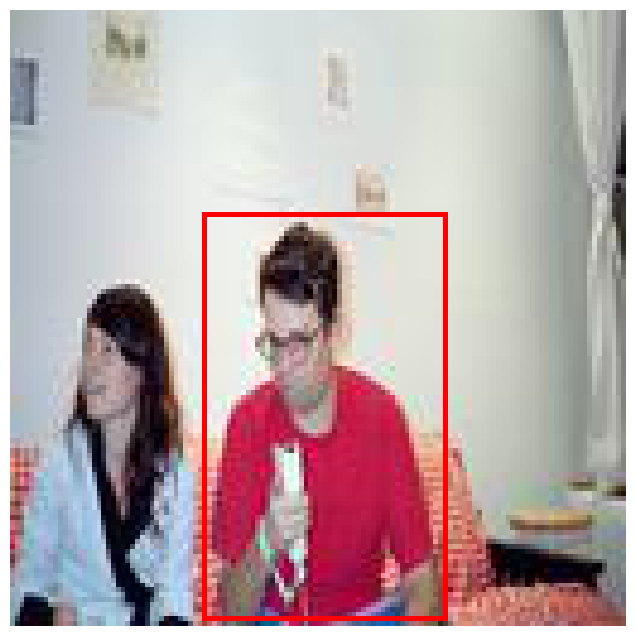

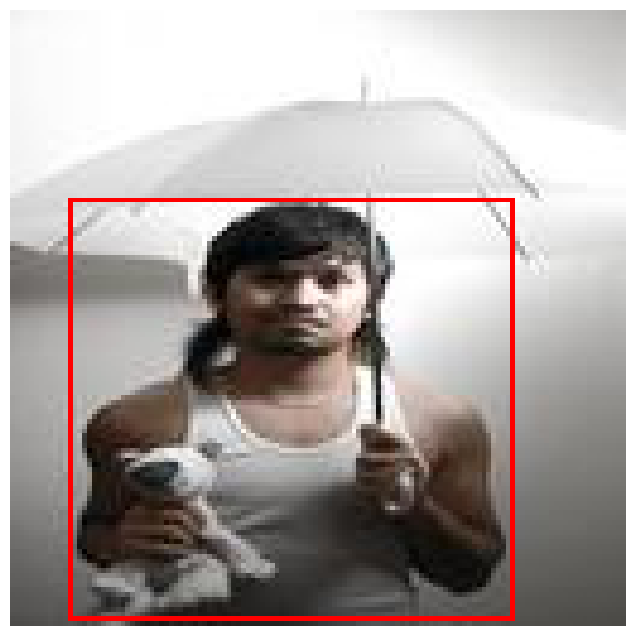

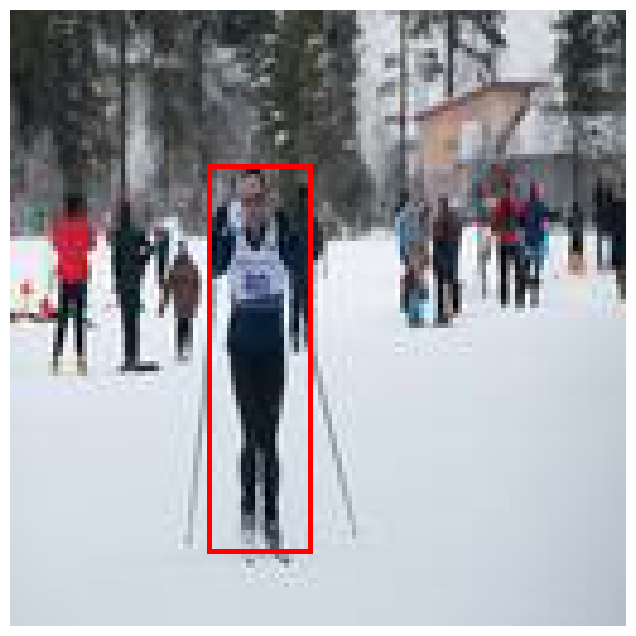

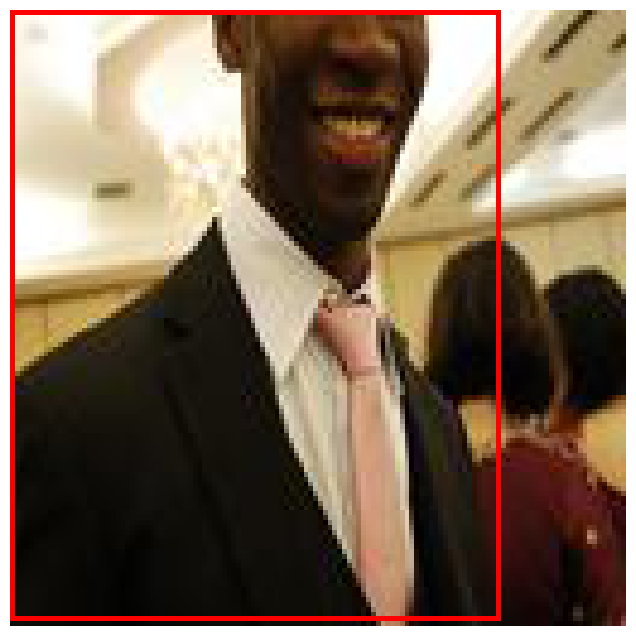

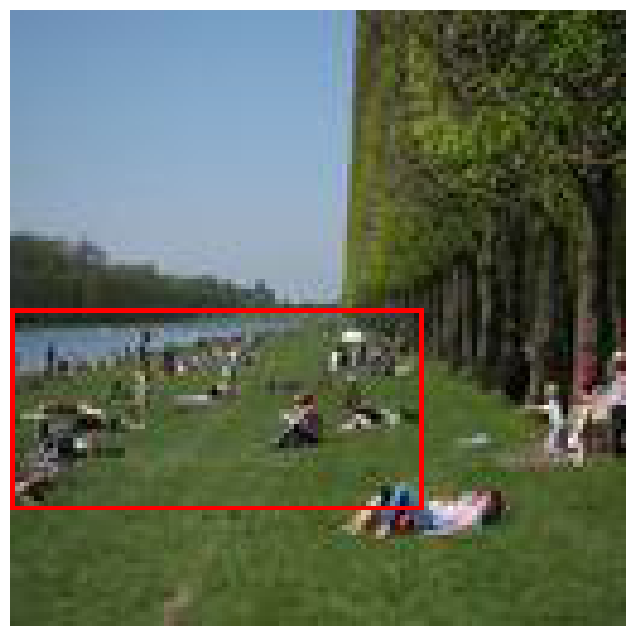

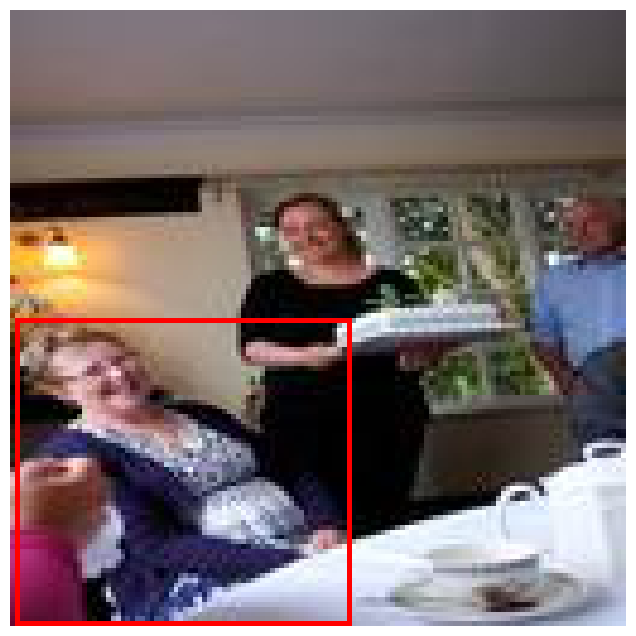

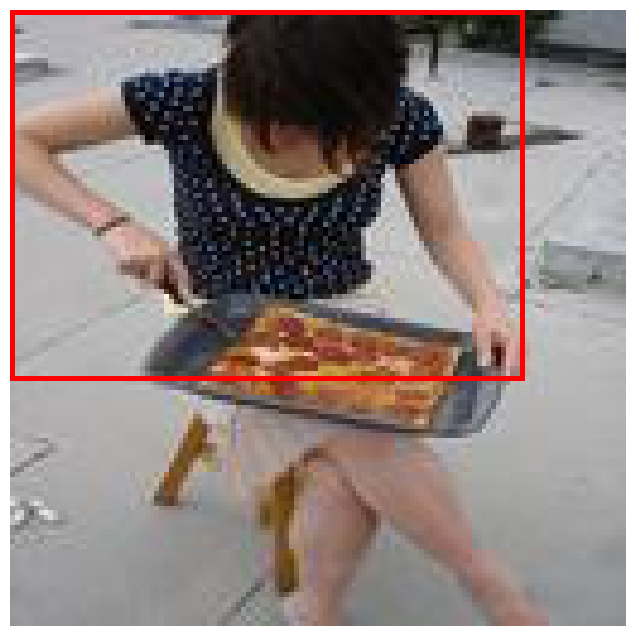

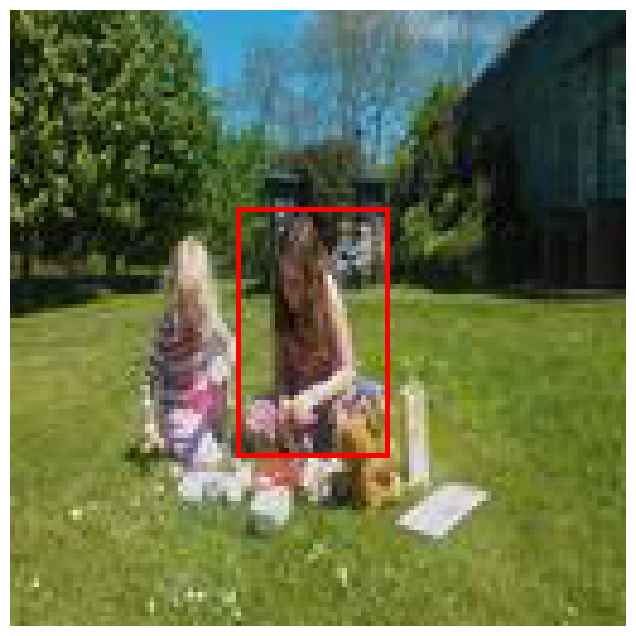

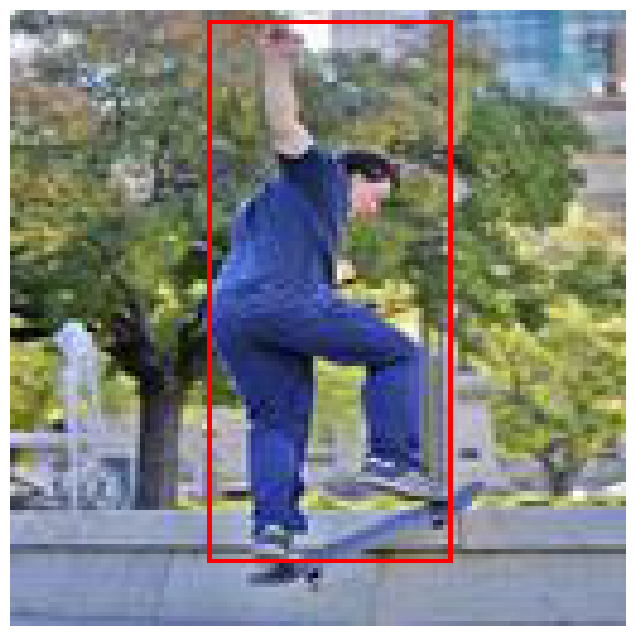

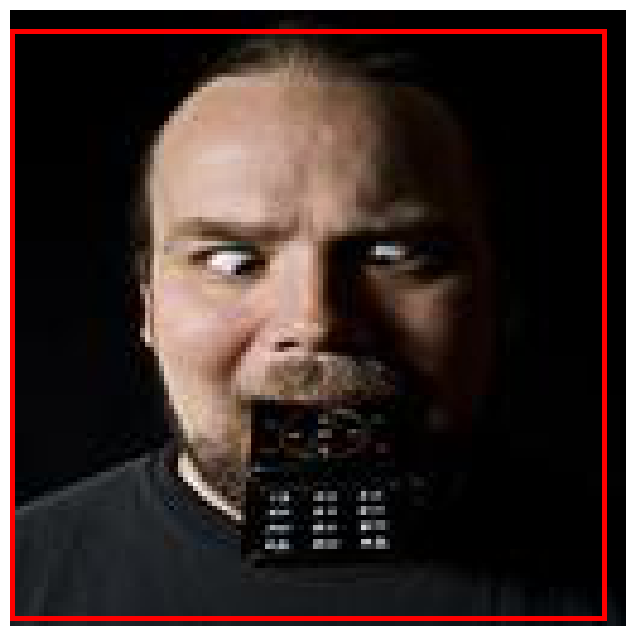

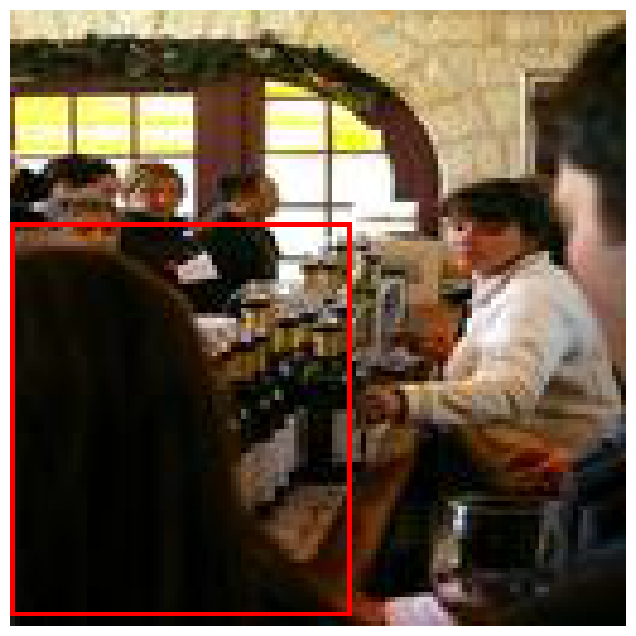

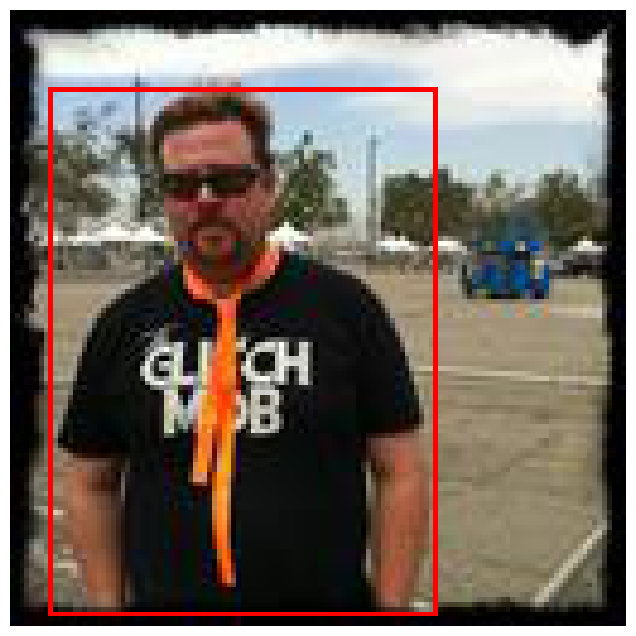

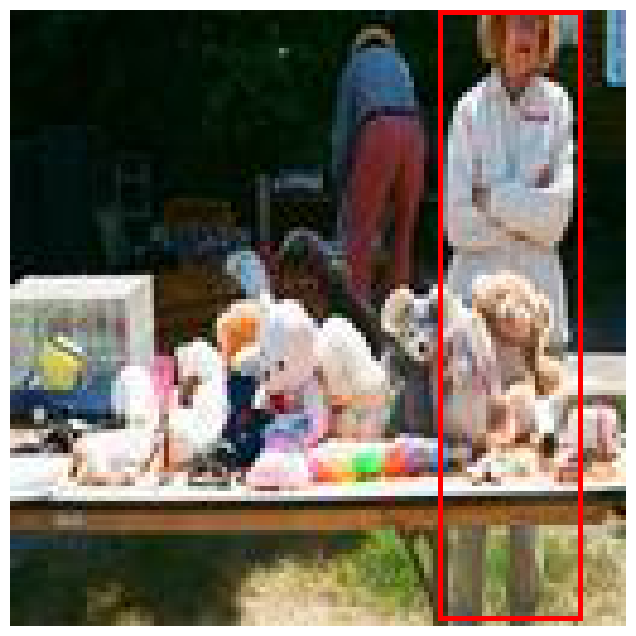

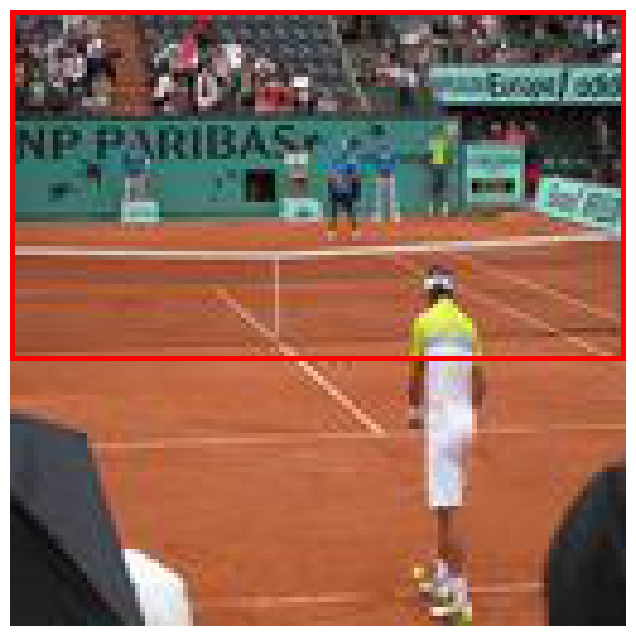

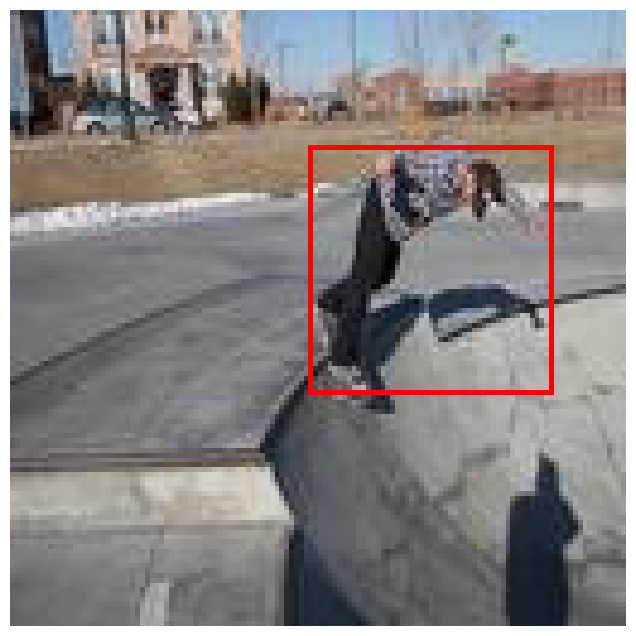

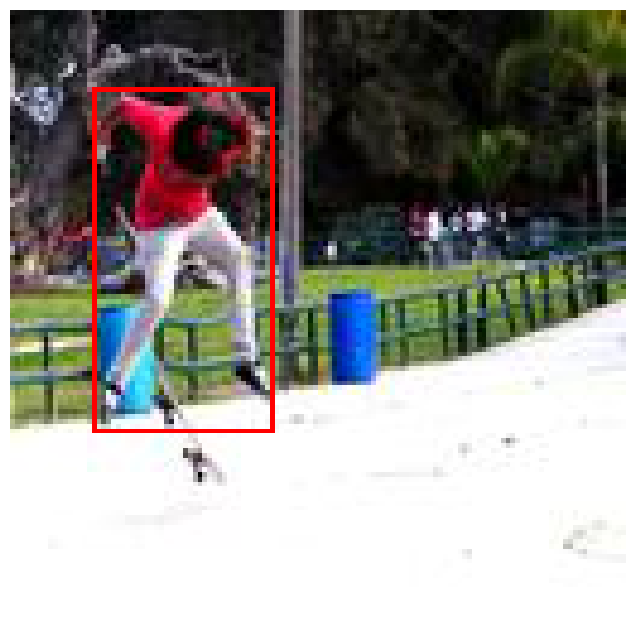

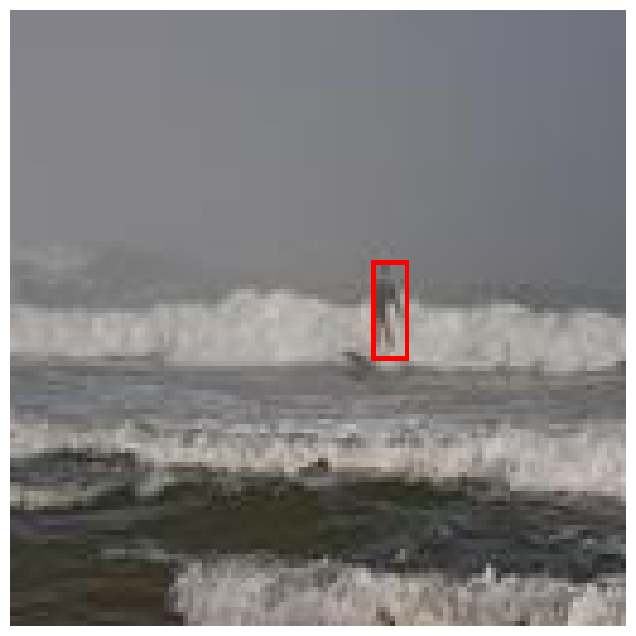

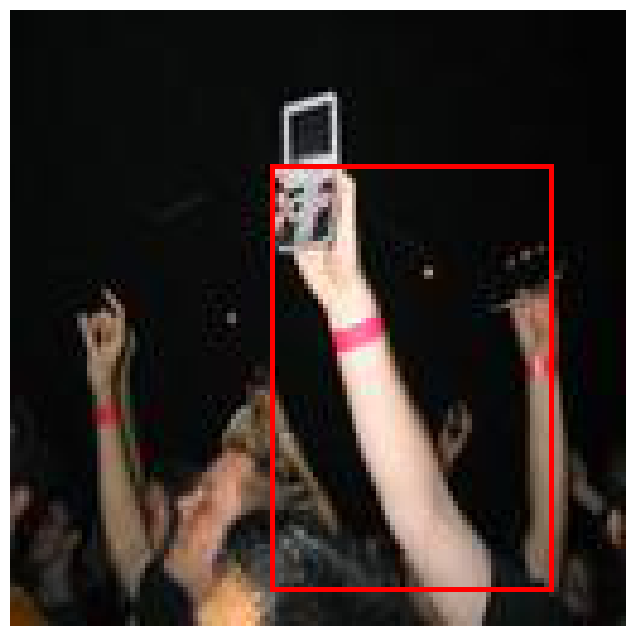

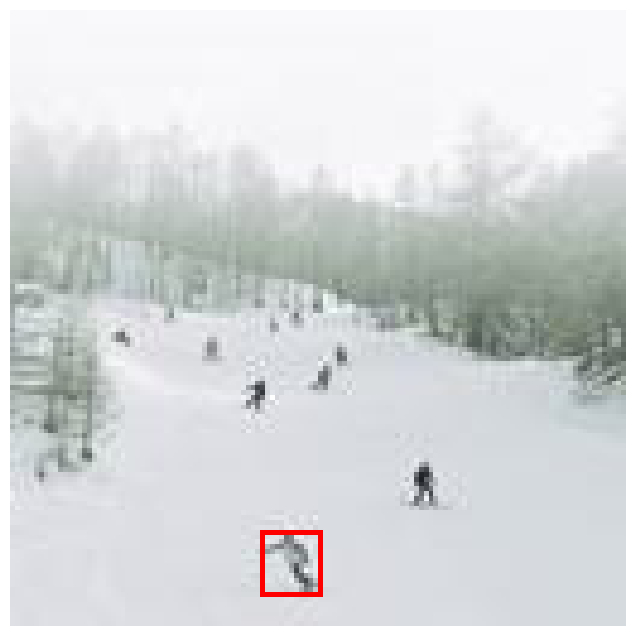

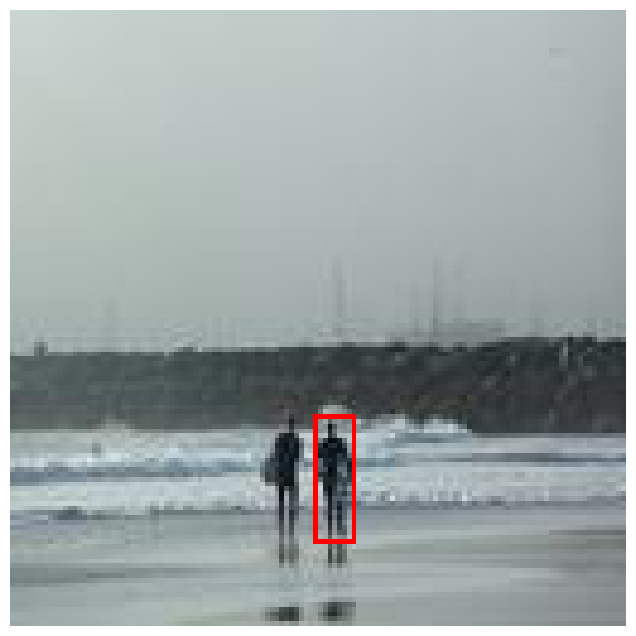

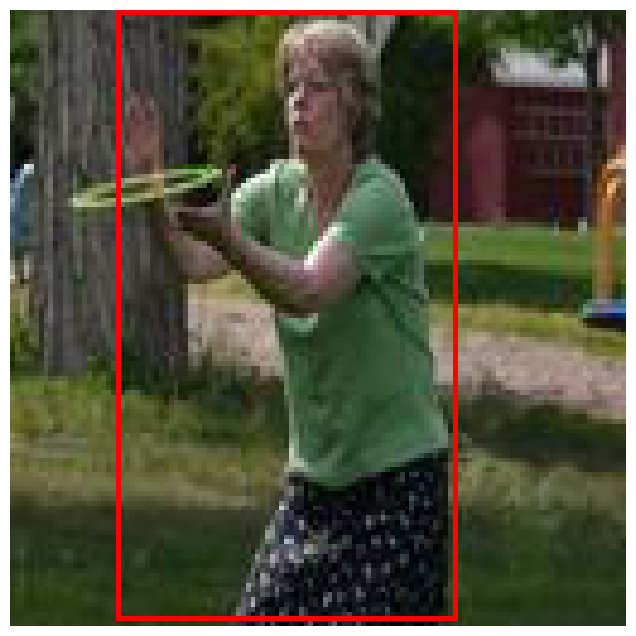

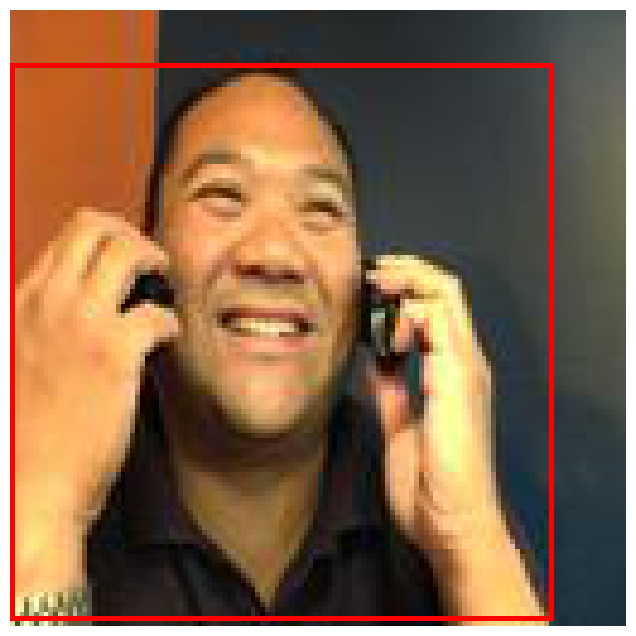

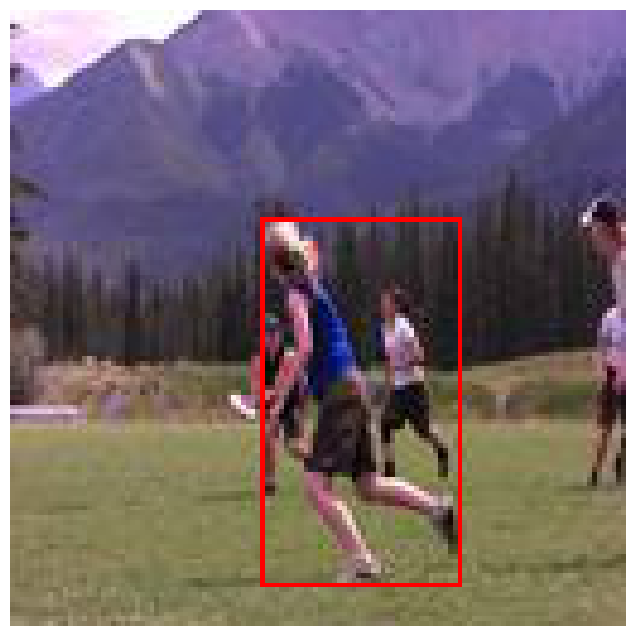

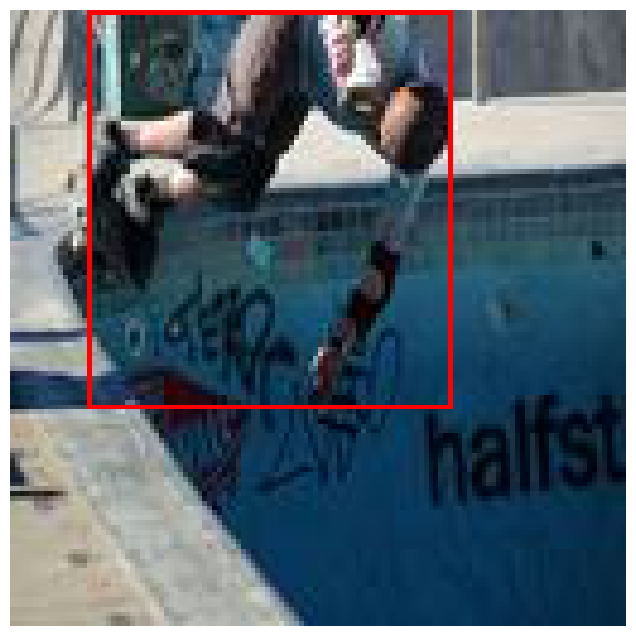

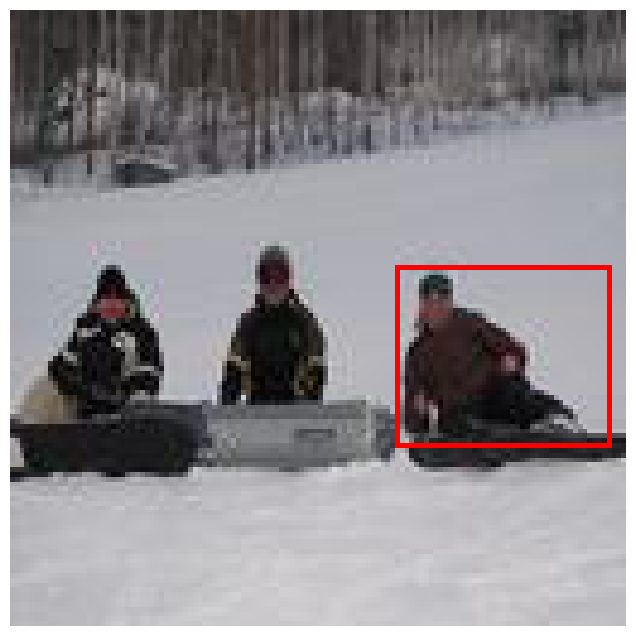

In [11]:
json_path = paths["Preprocessed_Train_json"]
train_path = paths["Train_resized"]

with open(json_path, 'r') as f:
    coco_data = js.load(f)

    i=0

for img in coco_data:
    img_path = path.join(train_path, img["img_id"])
    if not path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    x, y, w, h = img["bbox"]
    cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    i+=1
    if i==100:
        break